In [ ]:
import pandas as pd
import numpy as np
import re, os, ast, glob
from collections import defaultdict, Counter
from pathlib import Path

In [ ]:
def find_repo_root(marker="setup.py"):
    path = Path.cwd()
    while not (path / marker).exists() and path != path.parent:
        path = path.parent
    return path

project_root = find_repo_root()

Mounted at /content/drive


In [3]:
# Original labels including A1, A2 (which were at index 31 and 32)
channels_labels = [
    "Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "FC5", "FC1", "FC2", "FC6", "T7",
    "C3", "C4", "T8", "TP9", "CP5", "CP1", "CP2", "CP6", "TP10", "P7", "P3", "Pz",
    "P4", "P8", "O1", "Oz", "O2", "Iz", "AF7", "AF3", "AFz", "AF4",
    "AF8", "F5", "F1", "F2", "F6", "FT7", "FC3", "FCz", "FC4", "FT8", "C5", "C1",
    "C2", "C6", "TP7", "CP3", "CPz", "CP4", "TP8", "P5", "P1", "P2", "P6", "PO7",
    "PO3", "POz", "PO4", "PO8"
]

eeg_info = {
    "Fp1": ("Frontal pole", "attention, emotion, executive function"),
    "Fp2": ("Frontal pole", "attention, emotion, executive function"),
    "F7": ("Frontal", "language processing, auditory processing"),
    "F3": ("Frontal", "working memory, decision making"),
    "Fz": ("Frontal midline", "executive control, motor planning"),
    "F4": ("Frontal", "working memory, decision making"),
    "F8": ("Frontal", "language, auditory response"),
    "FC5": ("Fronto-central", "speech perception, auditory-motor integration"),
    "FC1": ("Fronto-central", "motor planning, decision making"),
    "FC2": ("Fronto-central", "motor planning, decision making"),
    "FC6": ("Fronto-central", "auditory-motor integration"),
    "T7": ("Temporal", "primary auditory processing"),
    "C3": ("Central", "motor cortex - movement of right side"),
    "C4": ("Central", "motor cortex - movement of left side"),
    "T8": ("Temporal", "auditory association"),
    "TP9": ("Temporal-parietal", "sound localization, multisensory integration"),
    "CP5": ("Centro-parietal", "sensorimotor integration"),
    "CP1": ("Centro-parietal", "tactile processing, spatial attention"),
    "CP2": ("Centro-parietal", "tactile processing, spatial attention"),
    "CP6": ("Centro-parietal", "sensorimotor integration"),
    "TP10": ("Temporal-parietal", "sound localization, multisensory integration"),
    "P7": ("Parietal", "visual attention, spatial processing"),
    "P3": ("Parietal", "spatial awareness, somatosensory integration"),
    "Pz": ("Parietal midline", "visuospatial attention, awareness"),
    "P4": ("Parietal", "spatial awareness, somatosensory integration"),
    "P8": ("Parietal", "visual attention, spatial processing"),
    "O1": ("Occipital", "primary visual cortex (left visual field)"),
    "Oz": ("Occipital midline", "central visual processing"),
    "O2": ("Occipital", "primary visual cortex (right visual field)"),
    "Iz": ("Occipital", "visual association area"),
    "A1": ("Reference electrode", "reference"),
    "A2": ("Reference electrode", "reference"),
    "AF7": ("Anterior frontal", "language and auditory attention"),
    "AF3": ("Anterior frontal", "emotional control, working memory"),
    "AFz": ("Anterior frontal midline", "conflict monitoring, executive control"),
    "AF4": ("Anterior frontal", "emotional control, working memory"),
    "AF8": ("Anterior frontal", "language and auditory attention"),
    "F5": ("Frontal", "motor planning, cognitive control"),
    "F1": ("Frontal", "executive function, motor planning"),
    "F2": ("Frontal", "executive function, motor planning"),
    "F6": ("Frontal", "motor planning, cognitive control"),
    "FT7": ("Fronto-temporal", "auditory processing, speech perception"),
    "FC3": ("Fronto-central", "motor preparation, sensorimotor integration"),
    "FCz": ("Fronto-central midline", "motor control, attention"),
    "FC4": ("Fronto-central", "motor preparation, sensorimotor integration"),
    "FT8": ("Fronto-temporal", "auditory processing, speech perception"),
    "C5": ("Central", "motor cortex - movement of right limbs"),
    "C1": ("Central", "motor cortex - fine motor control (right)"),
    "C2": ("Central", "motor cortex - fine motor control (left)"),
    "C6": ("Central", "motor cortex - movement of left limbs"),
    "TP7": ("Temporal-parietal", "speech and language integration"),
    "CP3": ("Centro-parietal", "sensorimotor function, spatial processing"),
    "CPz": ("Centro-parietal midline", "sensorimotor integration"),
    "CP4": ("Centro-parietal", "sensorimotor function, spatial processing"),
    "TP8": ("Temporal-parietal", "speech and language integration"),
    "P5": ("Parietal", "visual attention, object recognition"),
    "P1": ("Parietal", "visual spatial processing"),
    "P2": ("Parietal", "visual spatial processing"),
    "P6": ("Parietal", "visual attention, object recognition"),
    "PO7": ("Parieto-occipital", "high-level visual processing"),
    "PO3": ("Parieto-occipital", "visual integration, object recognition"),
    "POz": ("Parieto-occipital midline", "visual attention and processing"),
    "PO4": ("Parieto-occipital", "visual integration, object recognition"),
    "PO8": ("Parieto-occipital", "high-level visual processing")
}

function_map = {
    "visual": ["visual", "object recognition", "spatial", "association", "high-level"],
    "auditory": ["auditory", "sound"],
    "language": ["language", "speech"],
    "motor": ["motor", "movement", "fine motor"],
    "executive": ["executive", "decision", "working memory", "control", "conflict"],
    "attention": ["attention", "focus"],
    "sensorimotor": ["sensorimotor", "tactile", "somatosensory"],
    "emotion": ["emotion", "emotional"],
}

def get_original_index(modified_index):
    return modified_index + 2 if modified_index >= 31 else modified_index

def describe_eeg_channels(indices):
    results = []
    for idx in indices:
        original_idx = get_original_index(idx)
        label = channels_labels[original_idx]
        region, modality = eeg_info.get(label, ("Unknown region", "unknown"))
        results.append({
            "index": idx,
            "original_label": label,
            "brain_region": region,
            "processing_type": modality
        })
    return results

def map_processing_type(processing_str):
    processing_str = processing_str.lower()
    tags = set()
    for group, keywords in function_map.items():
        for kw in keywords:
            if kw in processing_str:
                tags.add(group)
                break
    return list(tags)

# Parse a single Excel file
def parse_subject_file(filepath):
    df = pd.read_excel(filepath)
    df['Net Nodes'] = df['Net Nodes'].apply(ast.literal_eval)
    df['Processing Tags'] = df['Processing Type'].apply(map_processing_type)
    return df

# Process all Excel files in folder
def process_all_subjects(data_folder='data'):
    files = glob.glob(f"{data_folder}/nets_*_S*_*.xlsx")
    all_networks = []

    for file in files:
        match = re.search(r'nets_(3down|23|12)_(S\d+)_(\d+)\.xlsx', file)
        if not match:
            continue

        sigma, task, subject_id = match.groups()
        subject_id = f"sub{subject_id}"
        df = parse_subject_file(file)

        # Temp dict to collect unique networks
        net_dict = {}

        for _, row in df.iterrows():
            key = (task, subject_id, row['Net Nodes'])
            if key not in net_dict:
                net_dict[key] = {
                    'task': task,
                    'subject': subject_id,
                    'net_nodes': row['Net Nodes'],
                    'pec': row['Last PEC Value'],
                    'tags': set(row['Processing Tags']),
                }
            else:
                net_dict[key]['tags'].update(row['Processing Tags'])

        # Add unique entries to the result
        for net in net_dict.values():
            net['tags'] = sorted(net['tags'])  # optional
            all_networks.append(net)

    return all_networks

# Summarize per subject and group
def summarize_group(networks, top_n=3):
    per_subject_summary = defaultdict(lambda: defaultdict(list))
    group_tag_summary = defaultdict(list)

    for net in networks:
        subj = net['subject']
        task = net['task']
        key = f"{subj}_{task}"
        per_subject_summary[key]['networks'].append(net)

    per_subject_lowpec = {}
    for key, data in per_subject_summary.items():
        top_networks = sorted(data['networks'], key=lambda x: x['pec'])[:top_n]
        tag_counter = defaultdict(int)

        for net in top_networks:
            for tag in net['tags']:
                tag_counter[tag] += 1
                group_tag_summary[tag].append(net['pec'])

        per_subject_lowpec[key] = tag_counter

    return per_subject_lowpec, group_tag_summary

Check channel (node) functions:

In [4]:
# Generate node_functions from eeg_info
node_functions = {}

for idx, label in enumerate(channels_labels):
    region, functions = eeg_info.get(label, ("Unknown", ""))
    # Split the function string into a list of stripped keywords
    function_keywords = [f.strip() for f in functions.split(",") if f.strip()]
    node_functions[idx] = function_keywords

print("Node functions:", node_functions)

Node functions: {0: ['attention', 'emotion', 'executive function'], 1: ['attention', 'emotion', 'executive function'], 2: ['language processing', 'auditory processing'], 3: ['working memory', 'decision making'], 4: ['executive control', 'motor planning'], 5: ['working memory', 'decision making'], 6: ['language', 'auditory response'], 7: ['speech perception', 'auditory-motor integration'], 8: ['motor planning', 'decision making'], 9: ['motor planning', 'decision making'], 10: ['auditory-motor integration'], 11: ['primary auditory processing'], 12: ['motor cortex - movement of right side'], 13: ['motor cortex - movement of left side'], 14: ['auditory association'], 15: ['sound localization', 'multisensory integration'], 16: ['sensorimotor integration'], 17: ['tactile processing', 'spatial attention'], 18: ['tactile processing', 'spatial attention'], 19: ['sensorimotor integration'], 20: ['sound localization', 'multisensory integration'], 21: ['visual attention', 'spatial processing'], 22

In [5]:
# All functions considered
function_weights = {
    # General / always-on
    'attention': 1,
    'executive function': 2,
    'working memory': 2,
    'emotional control': 4,
    'spatial awareness': 5,
    'sensorimotor integration': 6,
    'visual attention': 7,
    'visual processing': 8,

    # Visual task-specific
    'primary visual cortex (left visual field)': 9,
    'primary visual cortex (right visual field)': 10,
    'visual spatial processing': 11,
    'high-level visual processing': 12,
    'object recognition': 13,
    'visual integration': 14,

    # Audio task-specific
    'auditory-motor integration': 15,
    'primary auditory processing': 16,
    'speech perception': 17,
    'speech and language integration': 18,
    'language': 19,
    'language processing': 20,
    'sound localization': 21,
    'auditory association': 22,
    'auditory processing': 23,

    # Other
    'motor planning': 24,
    'motor cortex - movement of left limbs': 25,
    'motor cortex - movement of right limbs': 26,
    'spatial processing': 27,
    'conflict monitoring': 28,
    'decision making': 29,
    'emotional regulation': 30,
    'tactile processing': 31,
}

def generate_function_map(eeg_info, function_weights):
    function_map = defaultdict(list)
    for ch, (_, functions_str) in eeg_info.items():
        for function in function_weights:
            # Match by substring (case-insensitive)
            if function.lower() in functions_str.lower():
                function_map[function].append(ch)
    return dict(function_map)

FUNCTION_MAP = generate_function_map(eeg_info, function_weights)
print(FUNCTION_MAP)

{'attention': ['Fp1', 'Fp2', 'CP1', 'CP2', 'P7', 'Pz', 'P8', 'AF7', 'AF8', 'FCz', 'P5', 'P6', 'POz'], 'executive function': ['Fp1', 'Fp2', 'F1', 'F2'], 'language': ['F7', 'F8', 'AF7', 'AF8', 'TP7', 'TP8'], 'language processing': ['F7'], 'auditory processing': ['F7', 'T7', 'FT7', 'FT8'], 'working memory': ['F3', 'F4', 'AF3', 'AF4'], 'decision making': ['F3', 'F4', 'FC1', 'FC2'], 'motor planning': ['Fz', 'FC1', 'FC2', 'F5', 'F1', 'F2', 'F6'], 'auditory-motor integration': ['FC5', 'FC6'], 'speech perception': ['FC5', 'FT7', 'FT8'], 'primary auditory processing': ['T7'], 'auditory association': ['T8'], 'sound localization': ['TP9', 'TP10'], 'sensorimotor integration': ['CP5', 'CP6', 'FC3', 'FC4', 'CPz'], 'tactile processing': ['CP1', 'CP2'], 'visual attention': ['P7', 'P8', 'P5', 'P6', 'POz'], 'spatial processing': ['P7', 'P8', 'CP3', 'CP4', 'P1', 'P2'], 'spatial awareness': ['P3', 'P4'], 'primary visual cortex (left visual field)': ['O1'], 'visual processing': ['Oz', 'PO7', 'PO8'], 'prima

Define path to the network files.

In [7]:
output_folder = project_root/"nets"
figures_folder = project_root

all_networks = process_all_subjects(data_folder=output_folder)
print(f"Found {len(all_networks)} total networks across all files.")

Found 4863 total networks across all files.


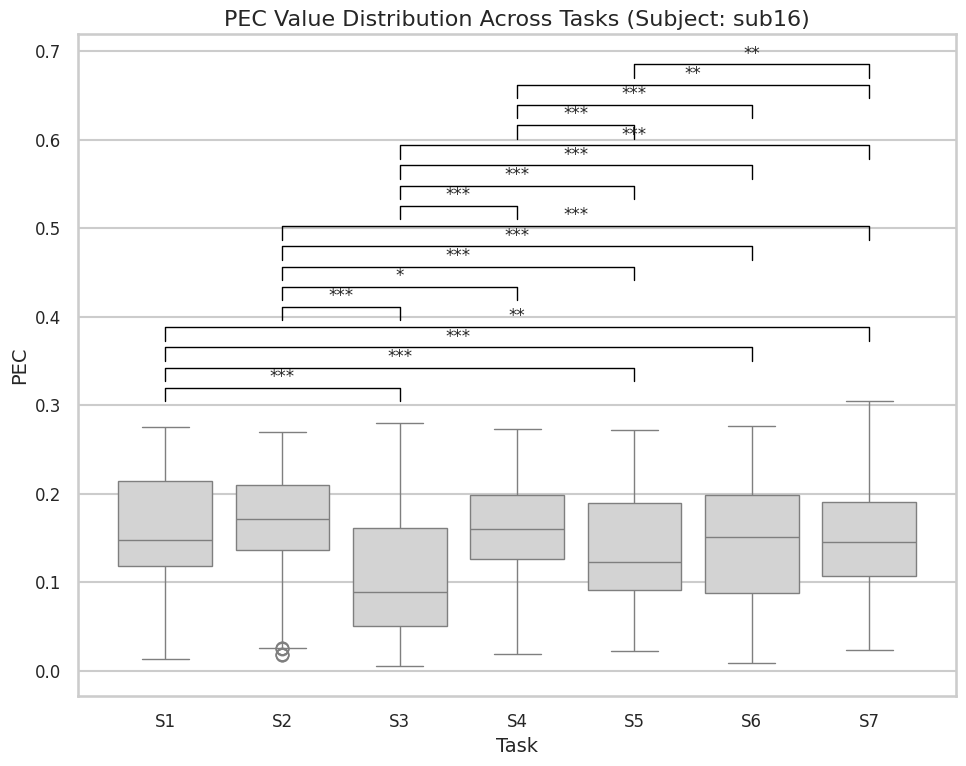

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Prepare DataFrame
df = pd.DataFrame(all_networks)

# Order tasks
task_order = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']
df['task'] = pd.Categorical(df['task'], categories=task_order, ordered=True)

# Test for normality (Shapiro-Wilk)
normality = {}
for task in task_order:
    pec_vals = df[df['task'] == task]['pec']
    if len(pec_vals) >= 3:  # Shapiro-Wilk requires at least 3 samples
        stat, p = shapiro(pec_vals)
        normality[task] = (p > 0.05)
    else:
        normality[task] = False

# Pairwise comparisons
comparisons = []
pvals = []
for task1, task2 in combinations(task_order, 2):
    group1 = df[df['task'] == task1]['pec']
    group2 = df[df['task'] == task2]['pec']

    if normality[task1] and normality[task2]:
        stat, p = ttest_ind(group1, group2, equal_var=False)
        test = 't-test'
    else:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
        test = 'MWU'

    comparisons.append((task1, task2, test))
    pvals.append(p)

# Apply Bonferroni correction
_, pvals_corrected, _, _ = multipletests(pvals, method='bonferroni')
significant = [(a, b, p) for (a, b, _), p in zip(comparisons, pvals_corrected) if p < 0.05]

# Plot
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='task', y='pec', data=df, color='lightgrey')
# sns.stripplot(x='task', y='pec', data=df, color='black', alpha=0.6, jitter=True)

# Annotation helper
def add_sig_annotation(ax, x1, x2, y, h, pval):
    barx = [x1, x1, x2, x2]
    bary = [y, y+h, y+h, y]
    ax.plot(barx, bary, color='black', linewidth=1)
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    else:
        stars = '*'
    ax.text((x1 + x2) * .5, y + h + 0.002, stars, ha='center', va='bottom', fontsize=12)

# Add significance annotations
y_max = df['pec'].max()
height = (y_max) * 0.05
offset = 0
for task1, task2, pval in significant:
    x1, x2 = task_order.index(task1), task_order.index(task2)
    y = y_max + offset
    add_sig_annotation(ax, x1, x2, y, height, pval)
    offset += height * 1.5  # vertical spacing between lines

# Labels
plt.title("PEC Value Distribution Across Tasks (Subject: sub16)", fontsize=16)
plt.xlabel("Task", fontsize=14)
plt.ylabel("PEC", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


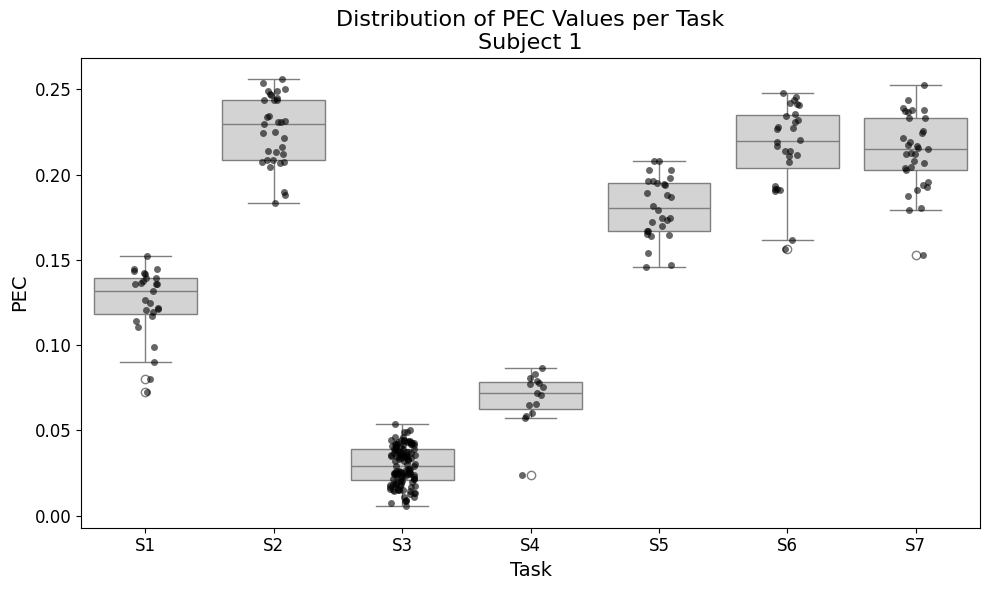

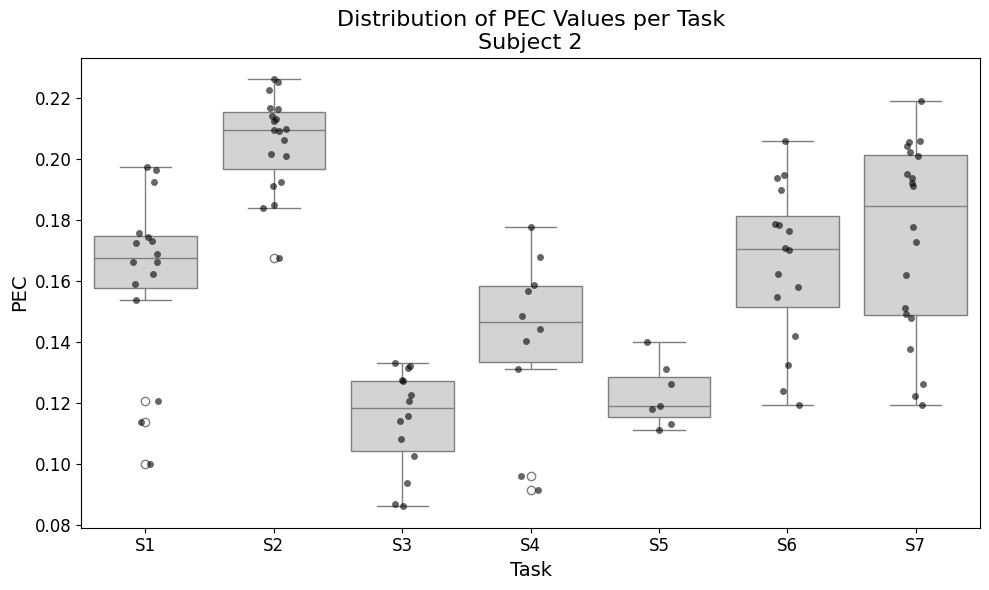

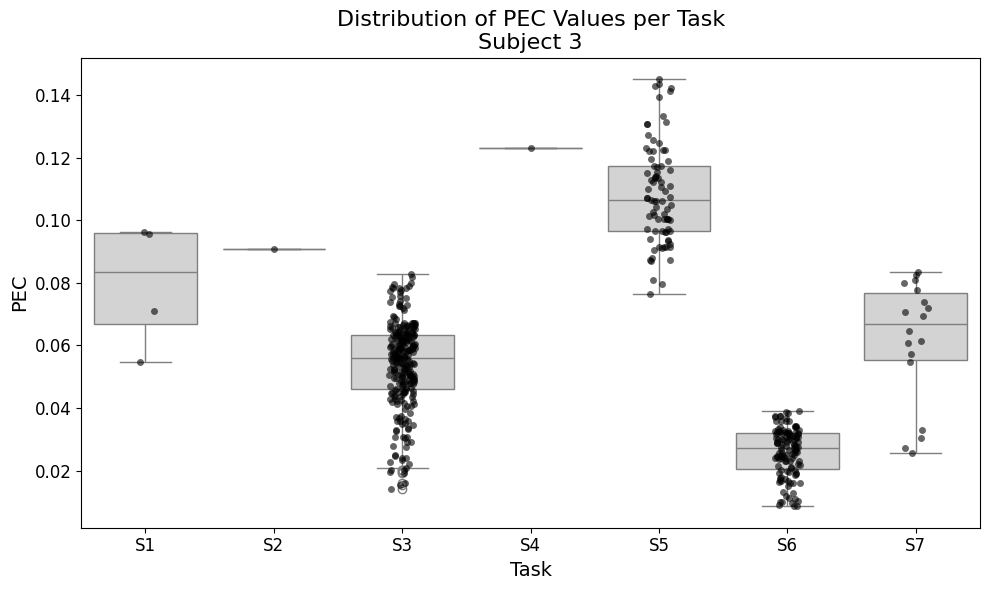

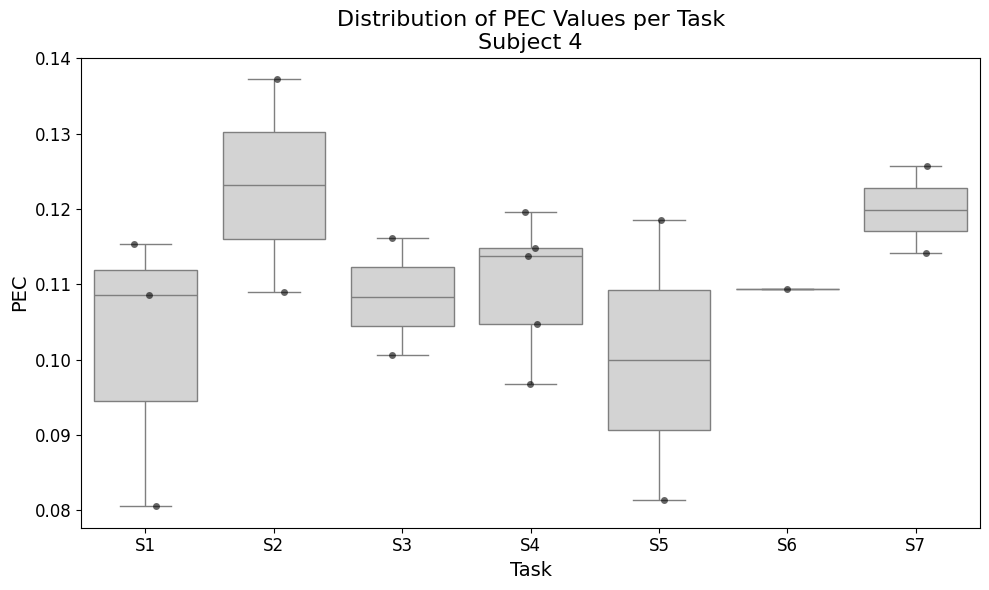

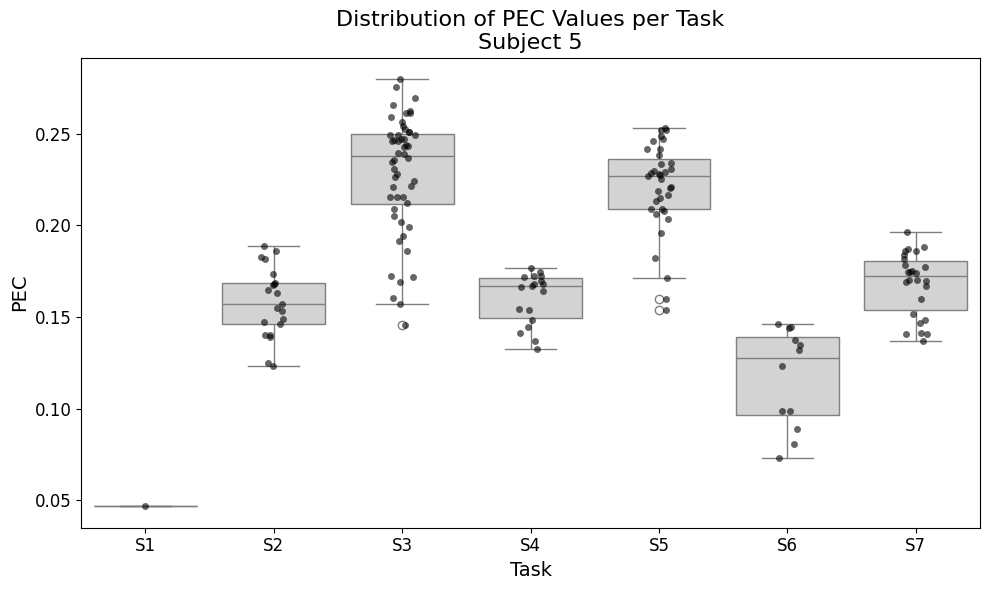

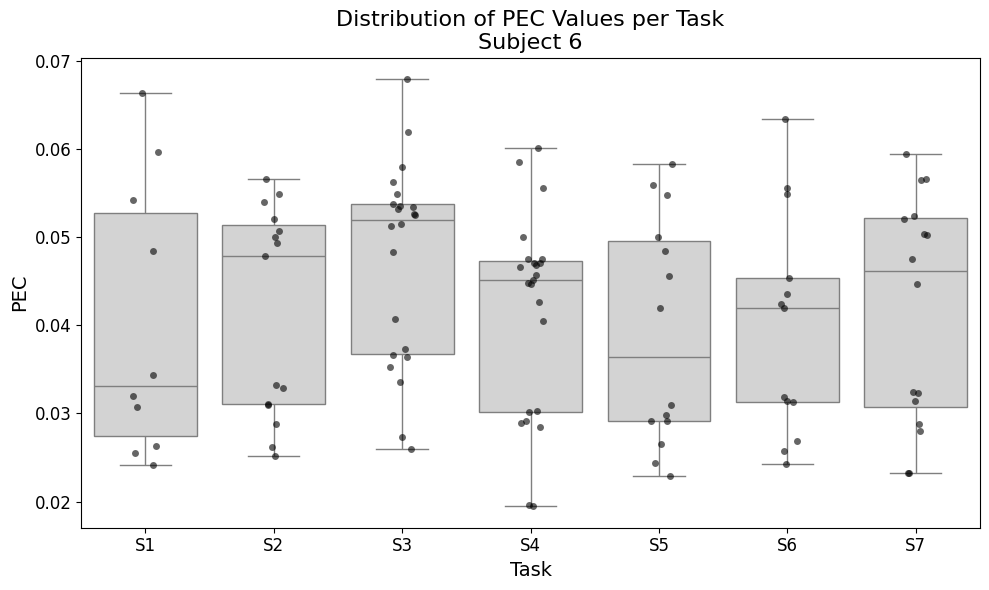

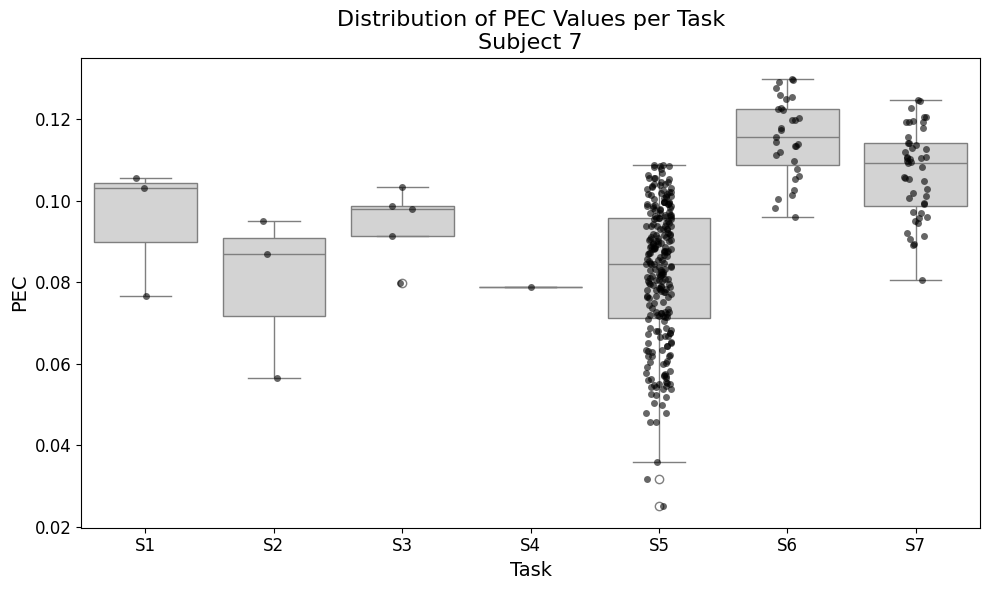

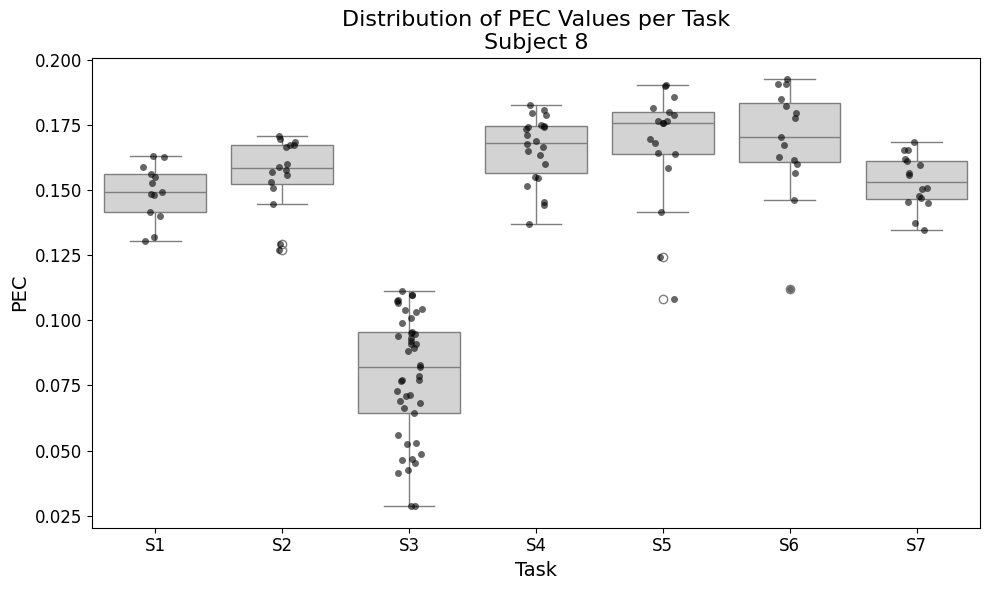

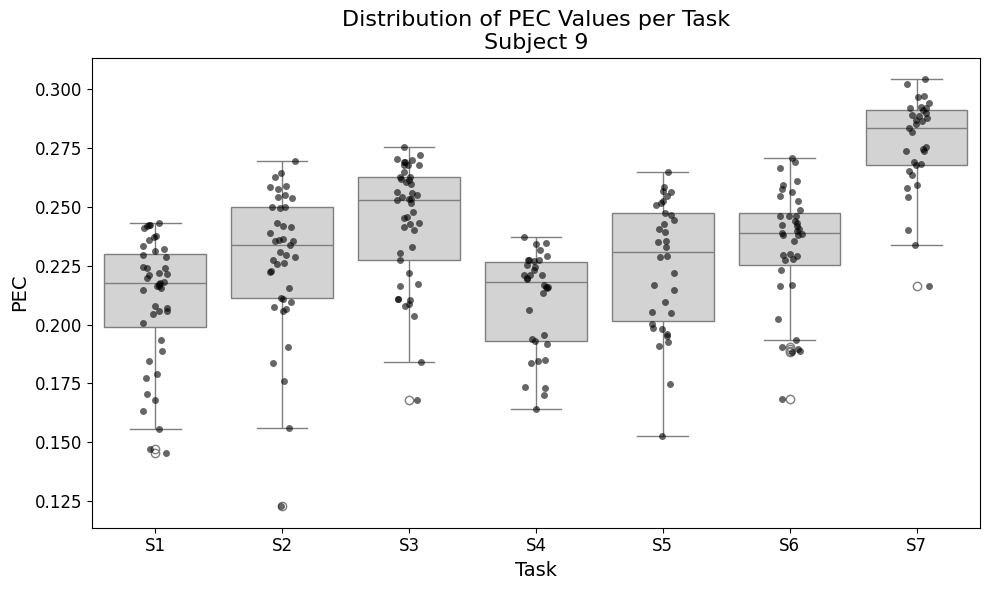

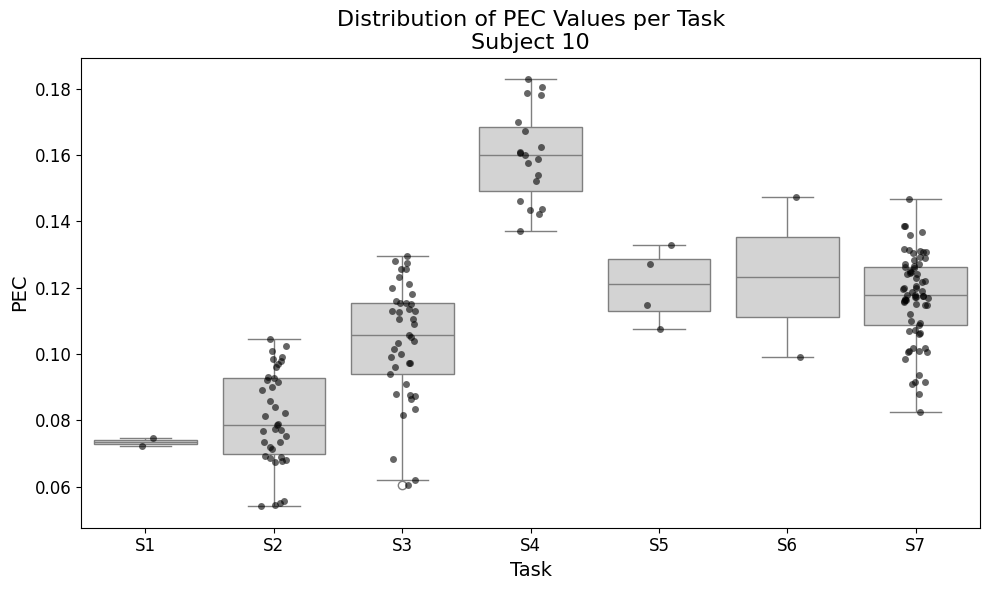

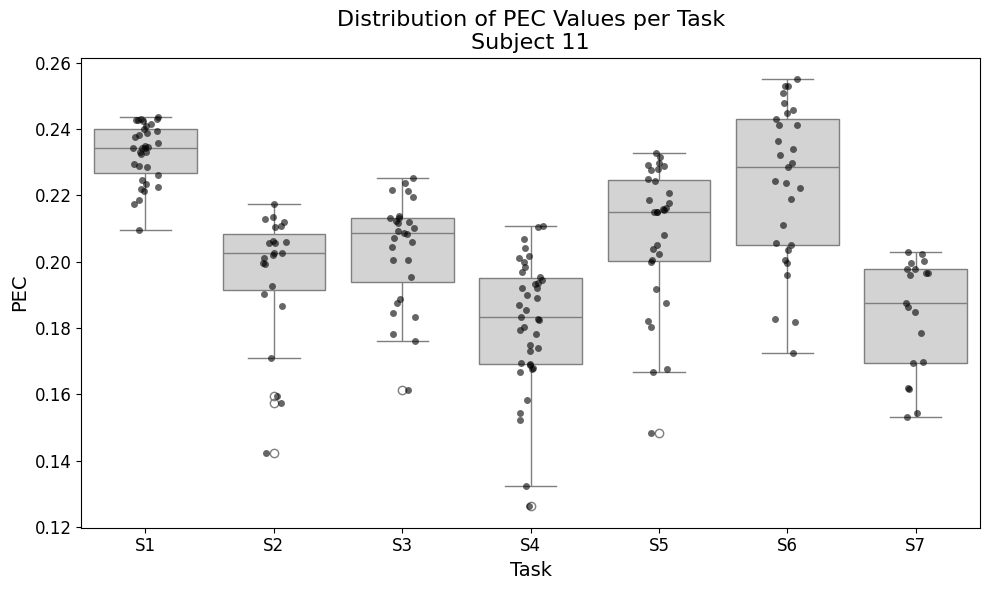

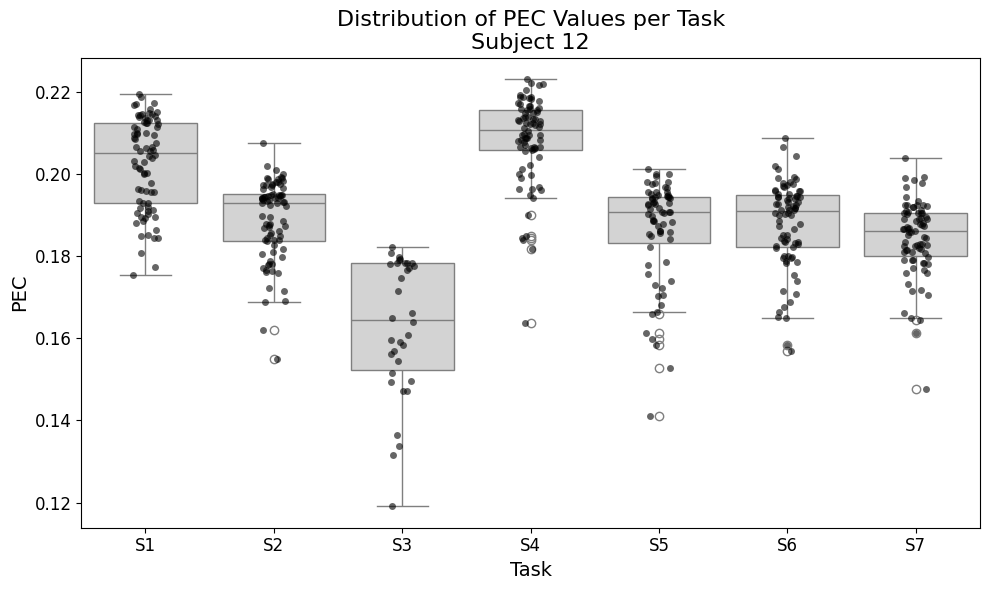

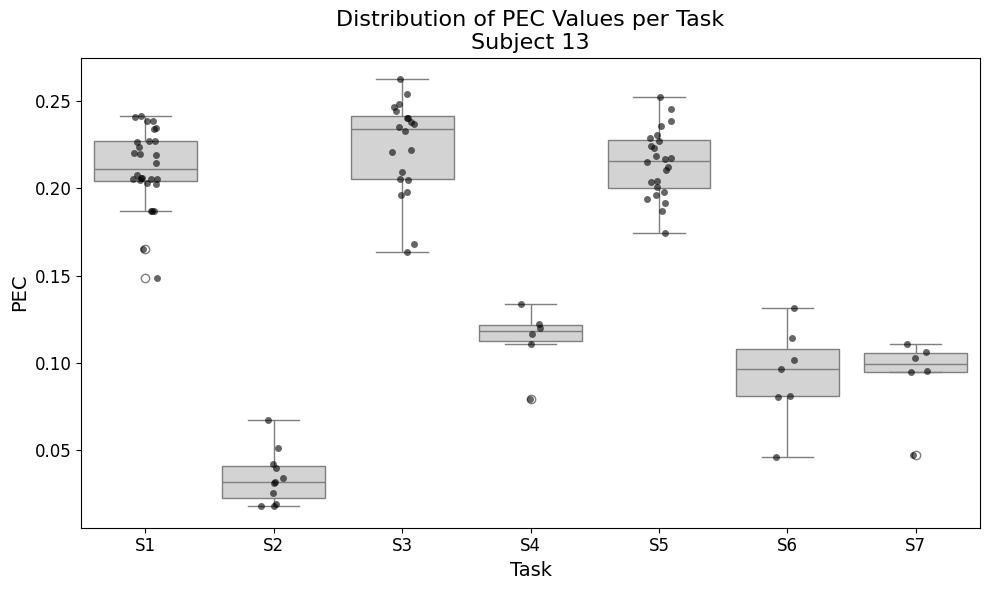

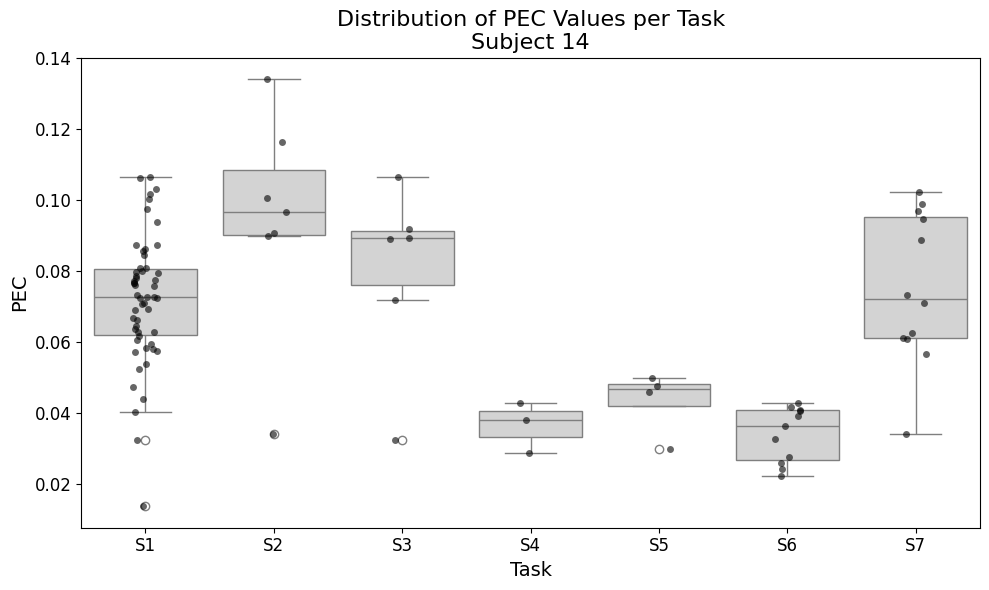

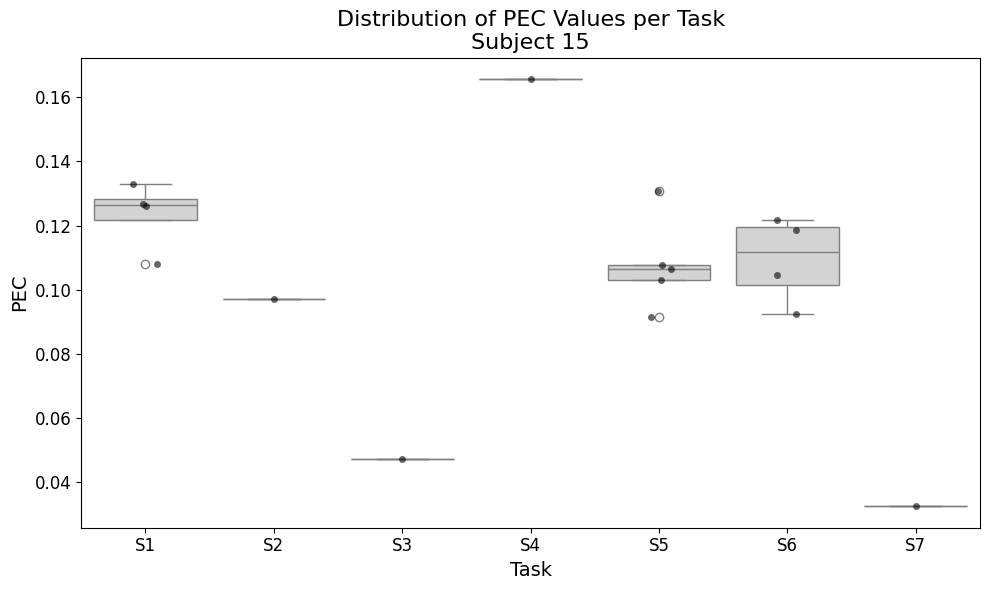

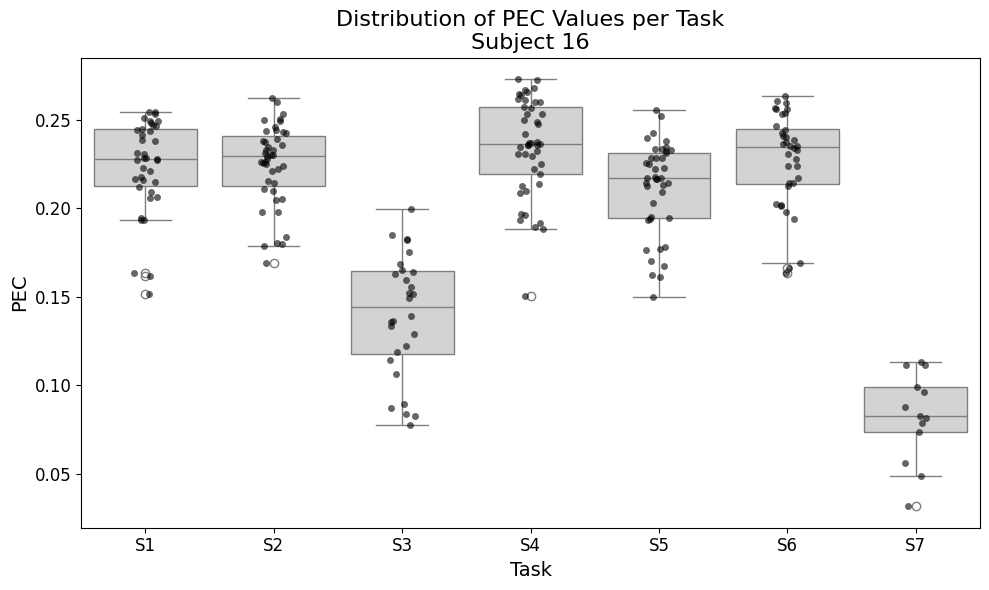

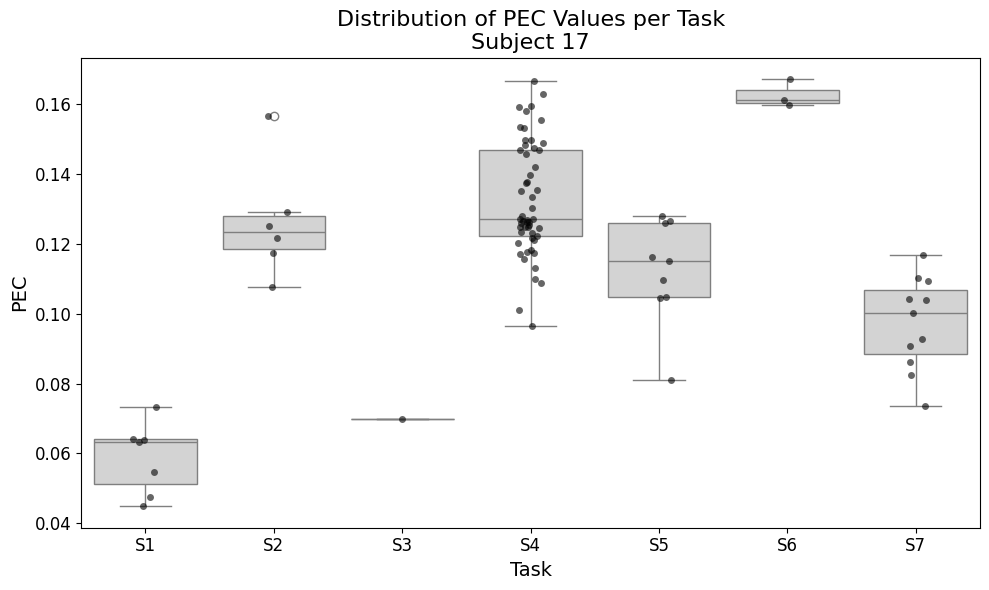

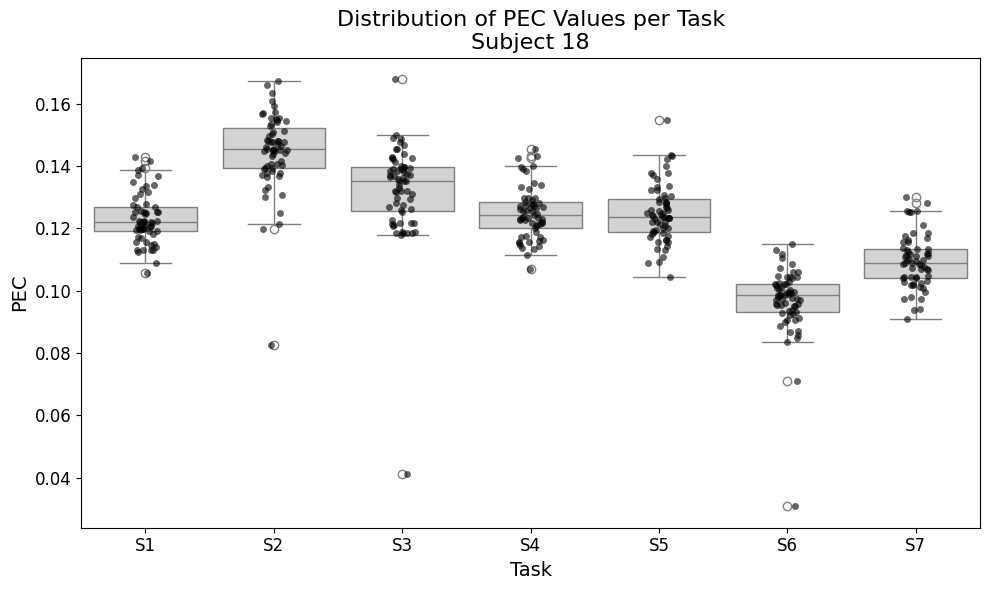

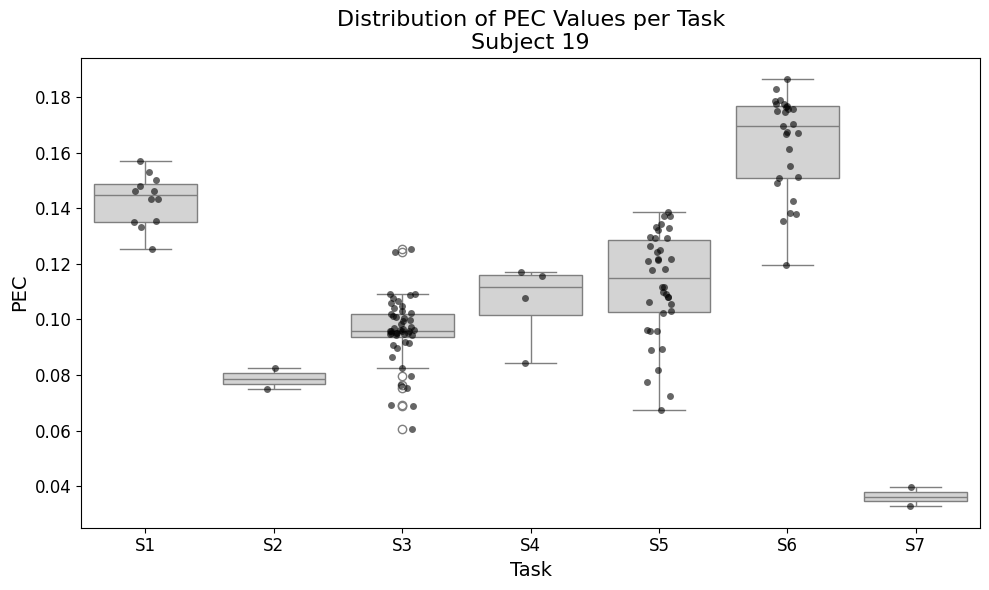

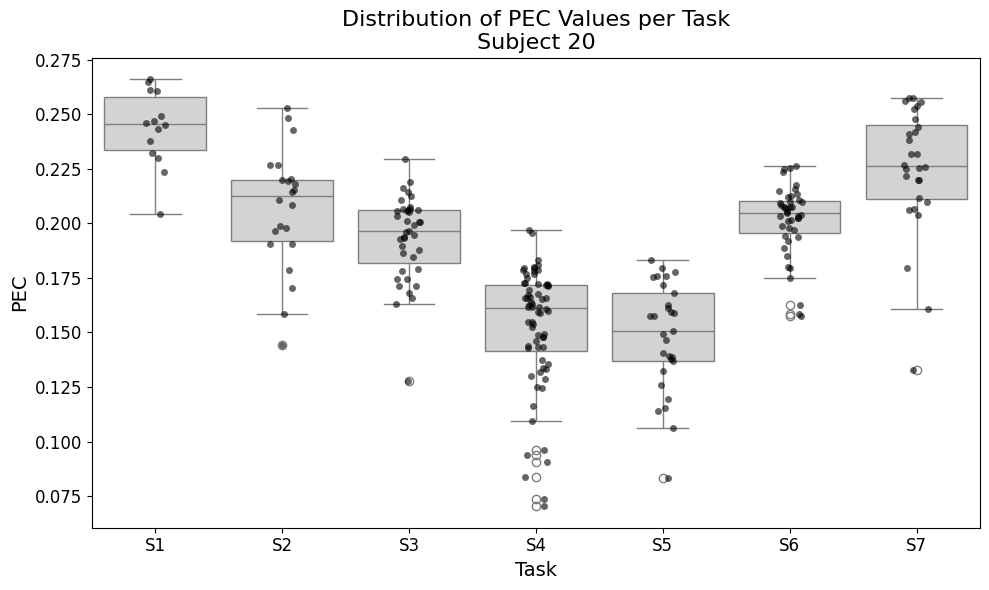

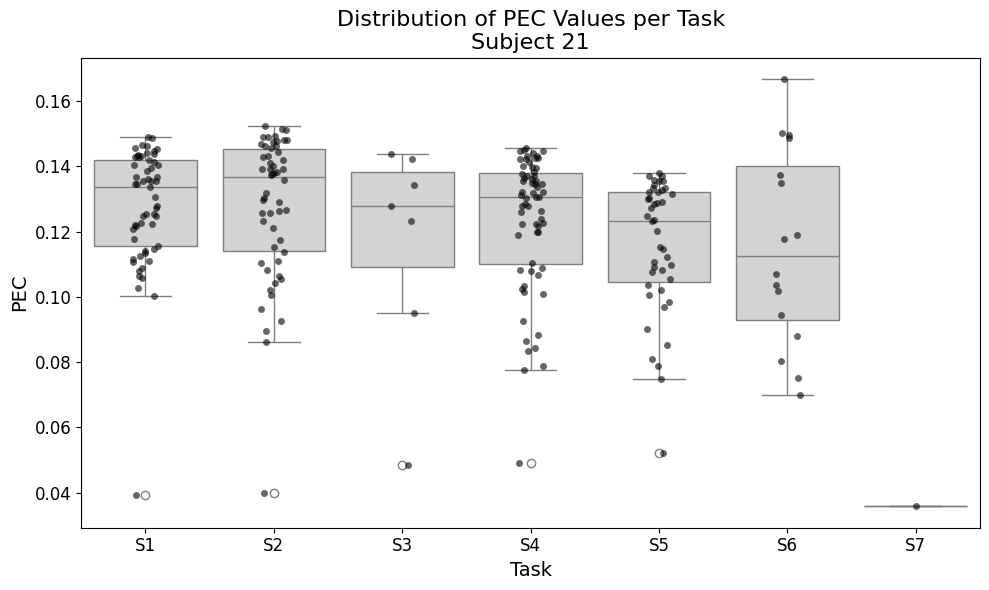

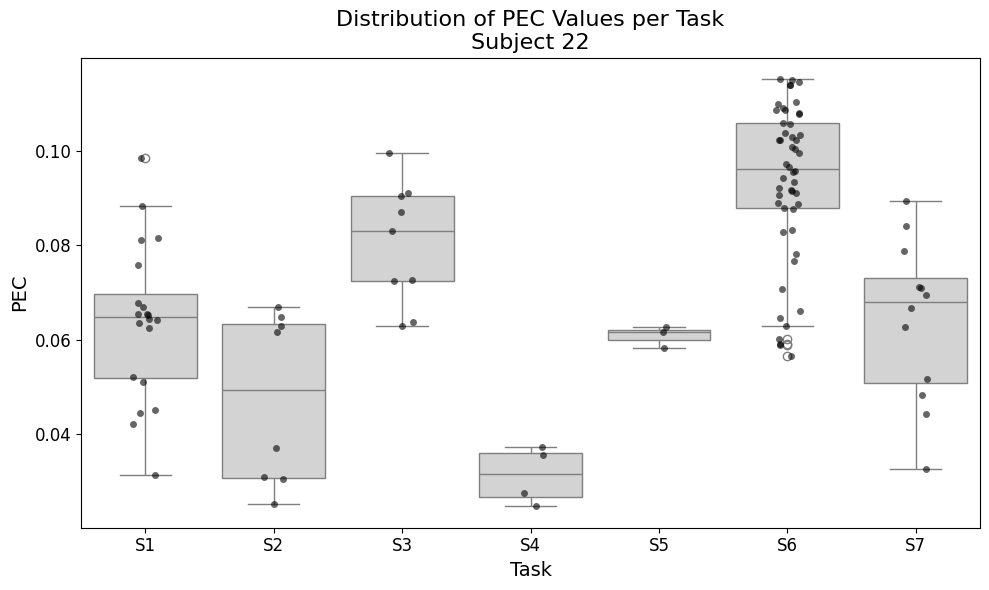

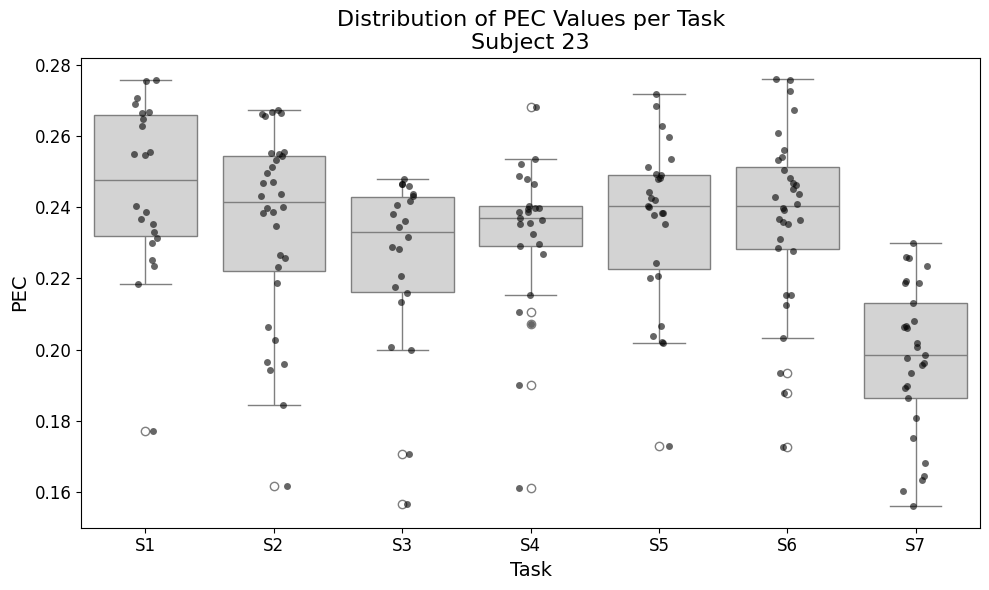

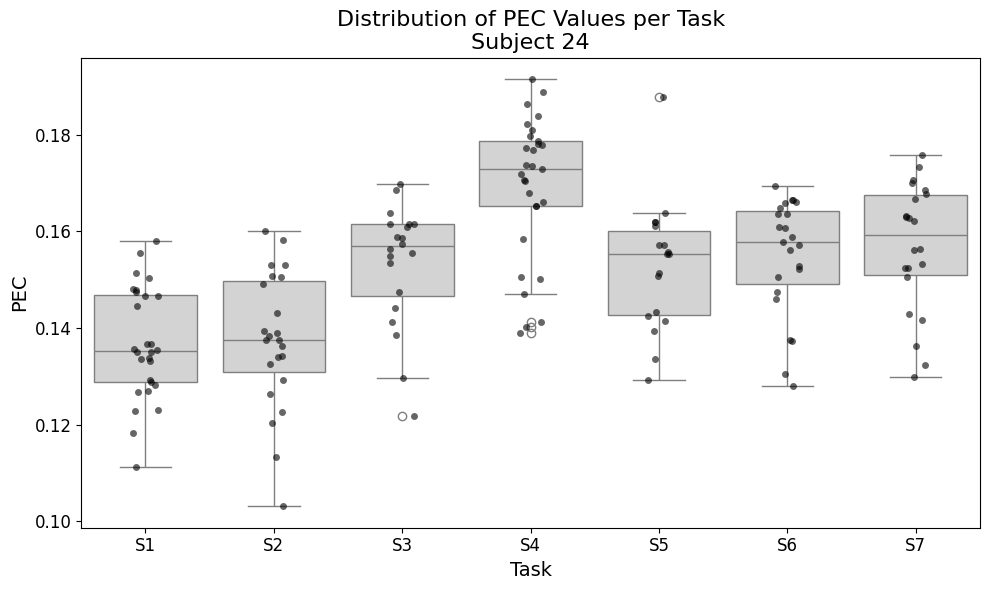

In [ ]:
for i in range(1,25):
  subject_id = f"sub{i}"
  subject_networks = [net for net in all_networks if net["subject"] == subject_id]

  # Convert list of dictionaries to DataFrame
  df = pd.DataFrame(subject_networks)

  task_order = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']
  df['task'] = pd.Categorical(df['task'], categories=task_order, ordered=True)

  # Plot boxplot of PEC values per task
  plt.figure(figsize=(10, 6))
  sns.boxplot(x='task', y='pec', data=df, color="lightgrey")
  sns.stripplot(x='task', y='pec', data=df, color='black', alpha=0.6, jitter=True)

  plt.title(f"Distribution of PEC Values per Task\nSubject {i}", fontsize=16)
  plt.xlabel("Task", fontsize=14)
  plt.ylabel("PEC", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  plt.tight_layout()
  plt.show()


Number of networks per task:
task
S1     27
S2     33
S3    122
S4     15
S5     28
S6     28
S7     33
Name: count, dtype: int64


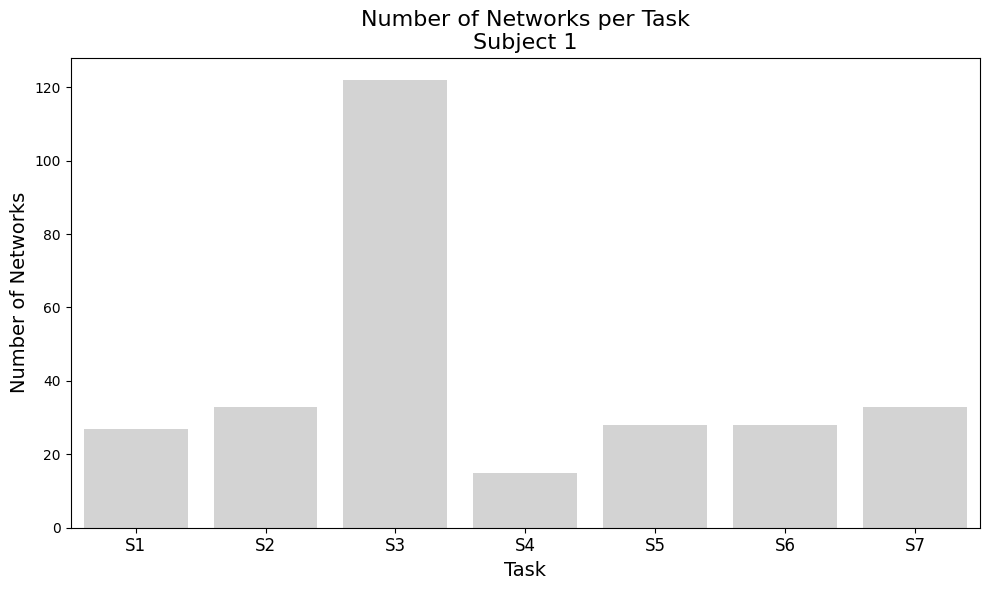

Number of networks per task:
task
S1    16
S2    19
S3    14
S4    10
S5     7
S6    16
S7    20
Name: count, dtype: int64


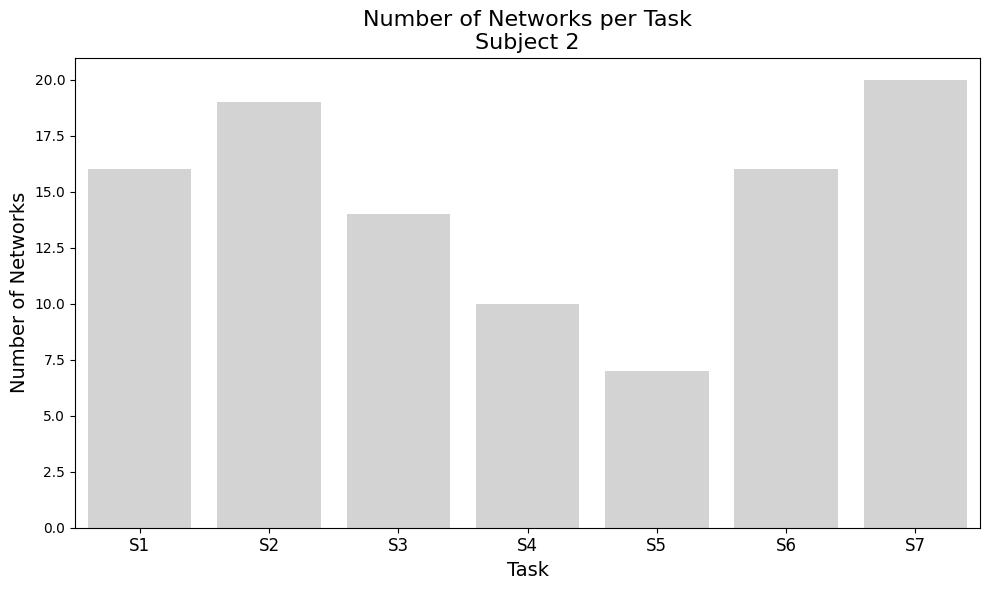

Number of networks per task:
task
S1      4
S2      1
S3    263
S4      1
S5     81
S6    123
S7     18
Name: count, dtype: int64


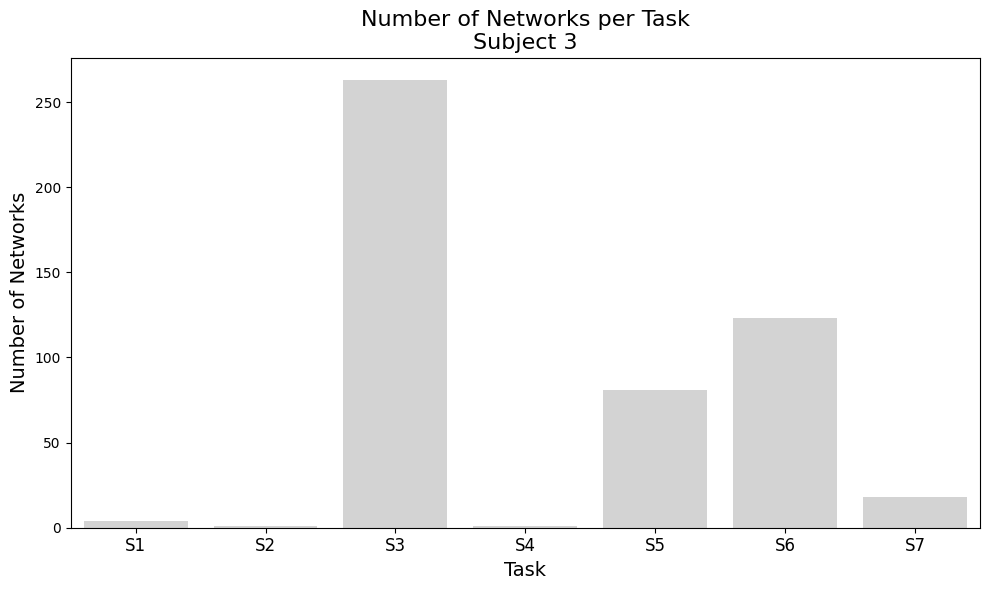

Number of networks per task:
task
S1    3
S2    2
S3    2
S4    5
S5    2
S6    1
S7    2
Name: count, dtype: int64


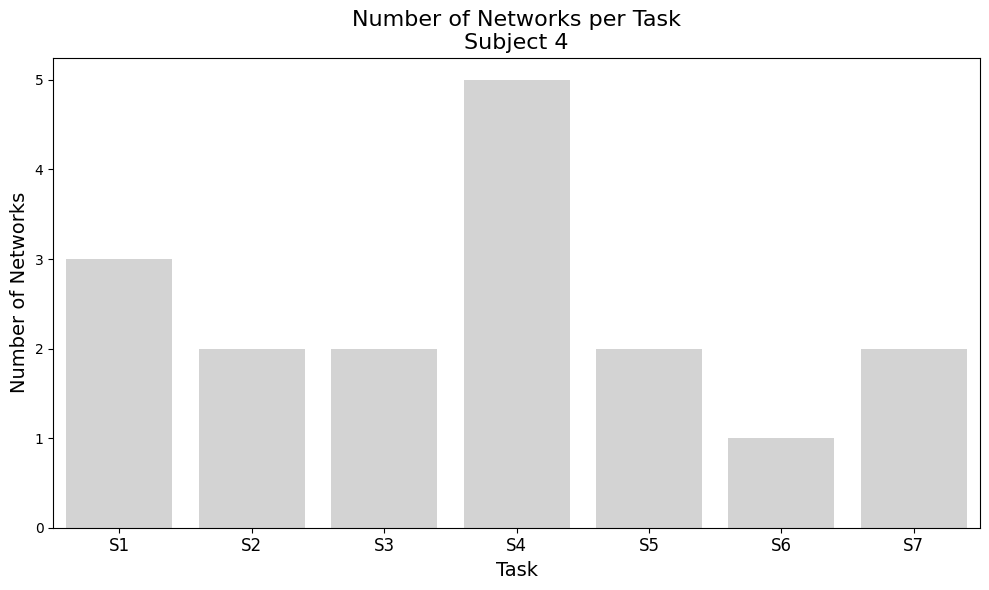

Number of networks per task:
task
S1     1
S2    21
S3    52
S4    18
S5    35
S6    12
S7    26
Name: count, dtype: int64


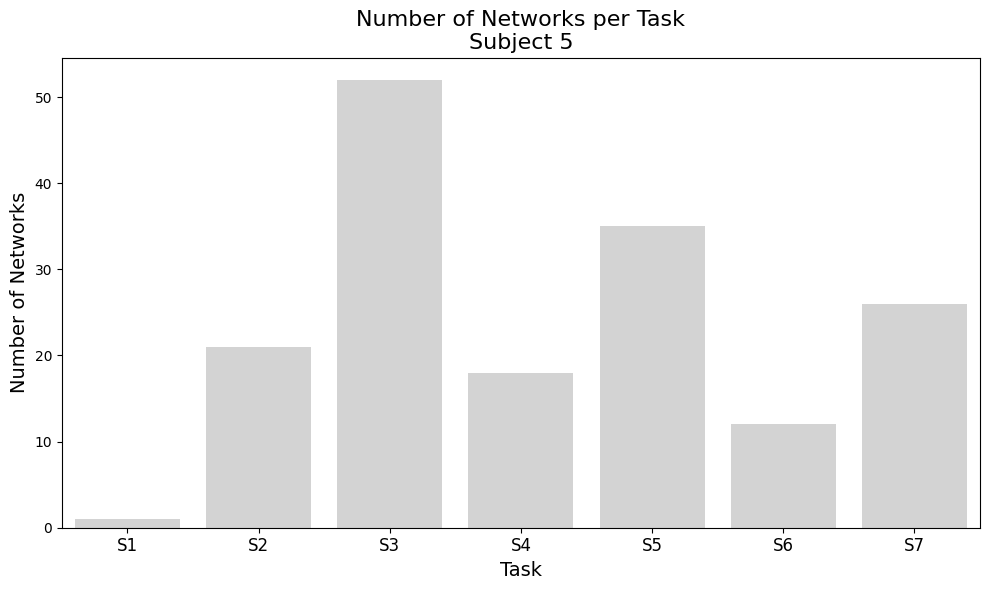

Number of networks per task:
task
S1    10
S2    15
S3    22
S4    23
S5    14
S6    13
S7    16
Name: count, dtype: int64


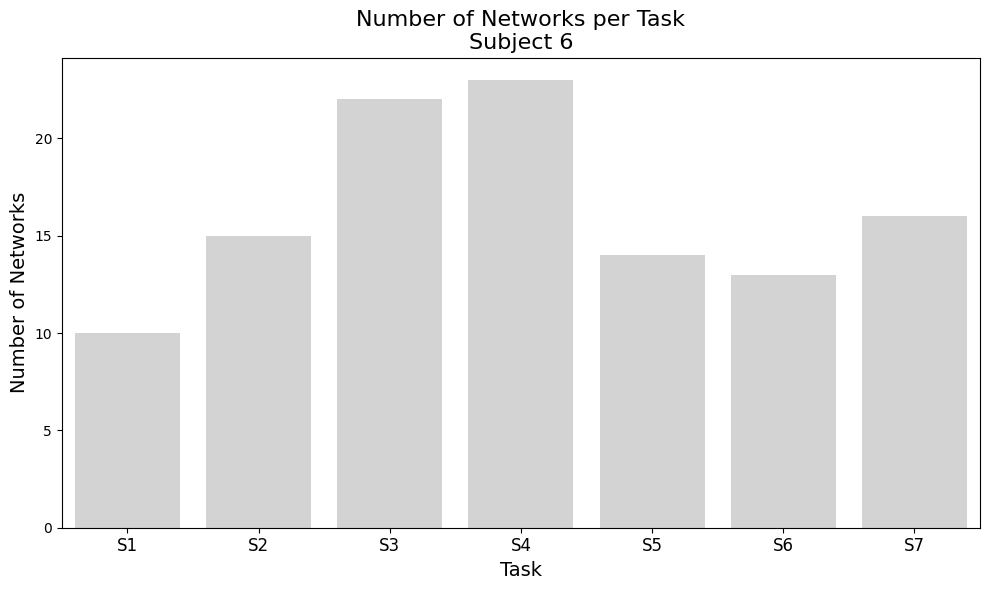

Number of networks per task:
task
S1      3
S2      3
S3      5
S4      1
S5    248
S6     31
S7     48
Name: count, dtype: int64


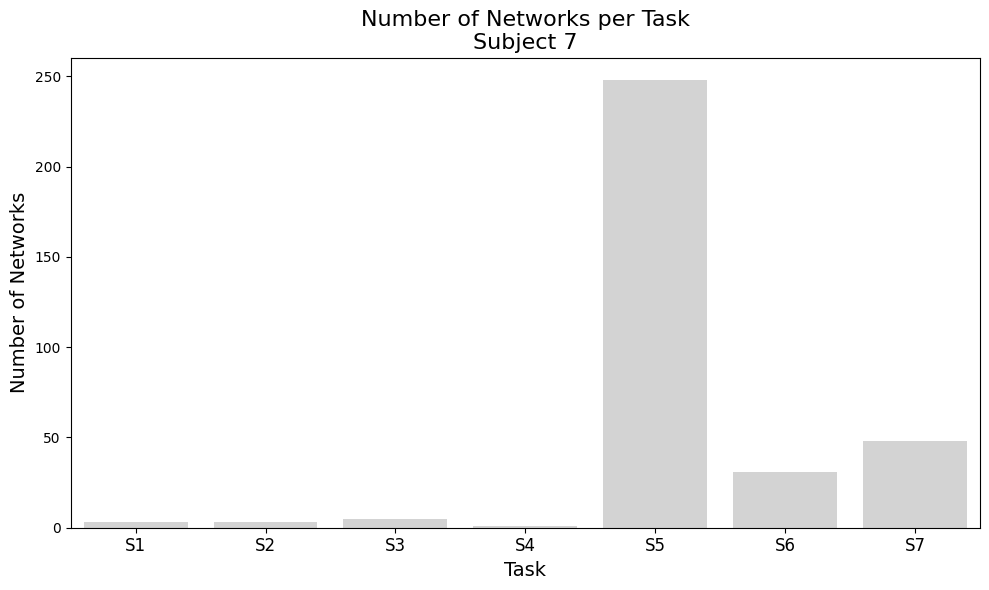

Number of networks per task:
task
S1    13
S2    16
S3    45
S4    22
S5    18
S6    15
S7    16
Name: count, dtype: int64


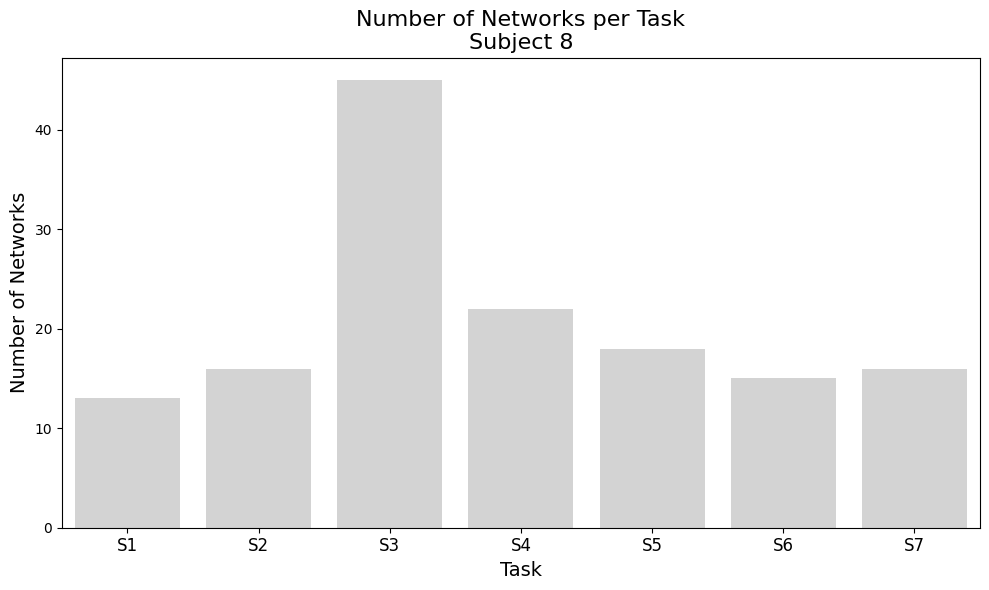

Number of networks per task:
task
S1    44
S2    41
S3    45
S4    34
S5    34
S6    39
S7    33
Name: count, dtype: int64


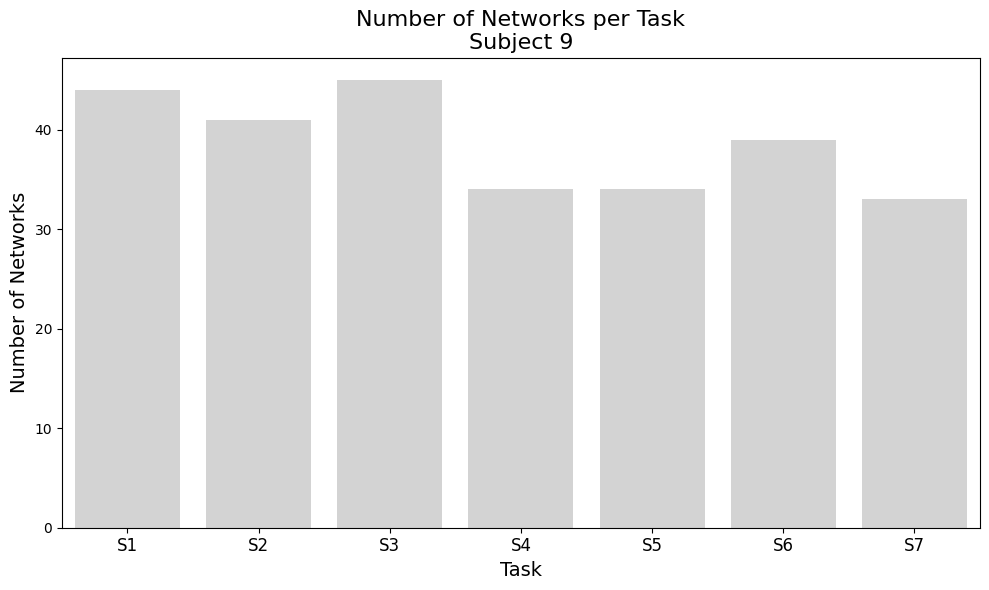

Number of networks per task:
task
S1     2
S2    38
S3    41
S4    19
S5     4
S6     2
S7    69
Name: count, dtype: int64


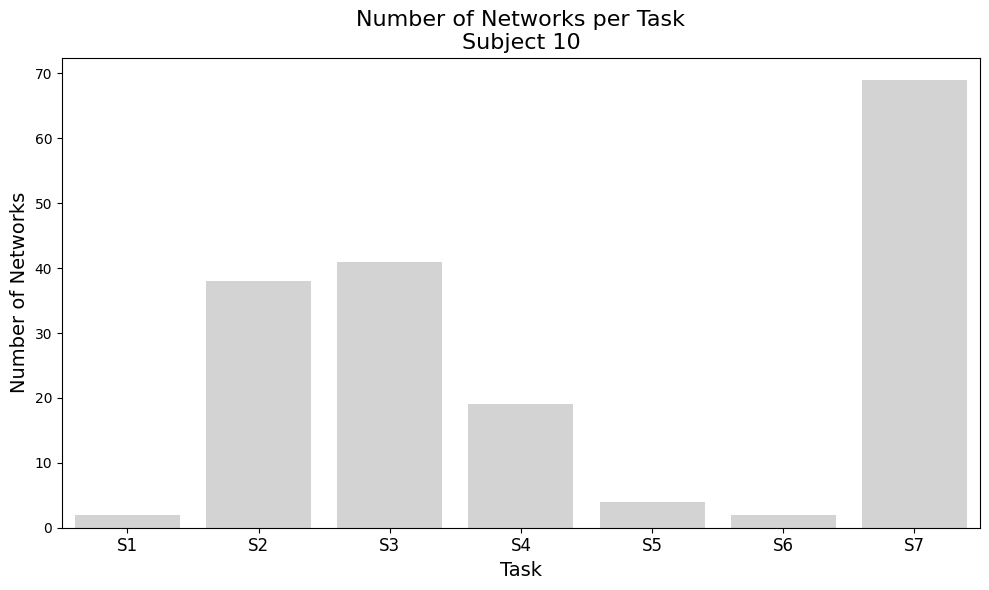

Number of networks per task:
task
S1    34
S2    23
S3    28
S4    39
S5    31
S6    29
S7    19
Name: count, dtype: int64


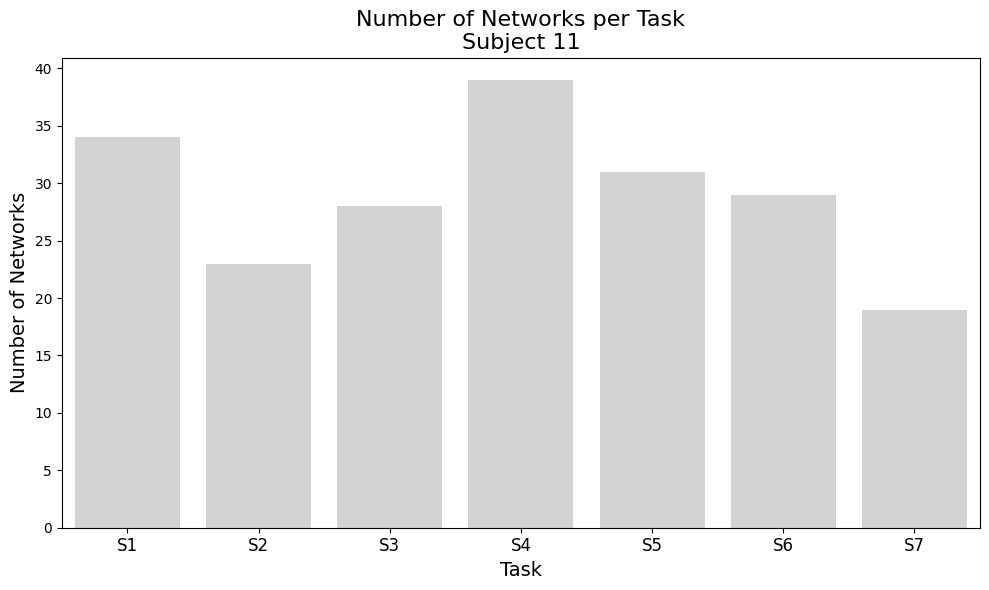

Number of networks per task:
task
S1    78
S2    81
S3    34
S4    78
S5    67
S6    80
S7    78
Name: count, dtype: int64


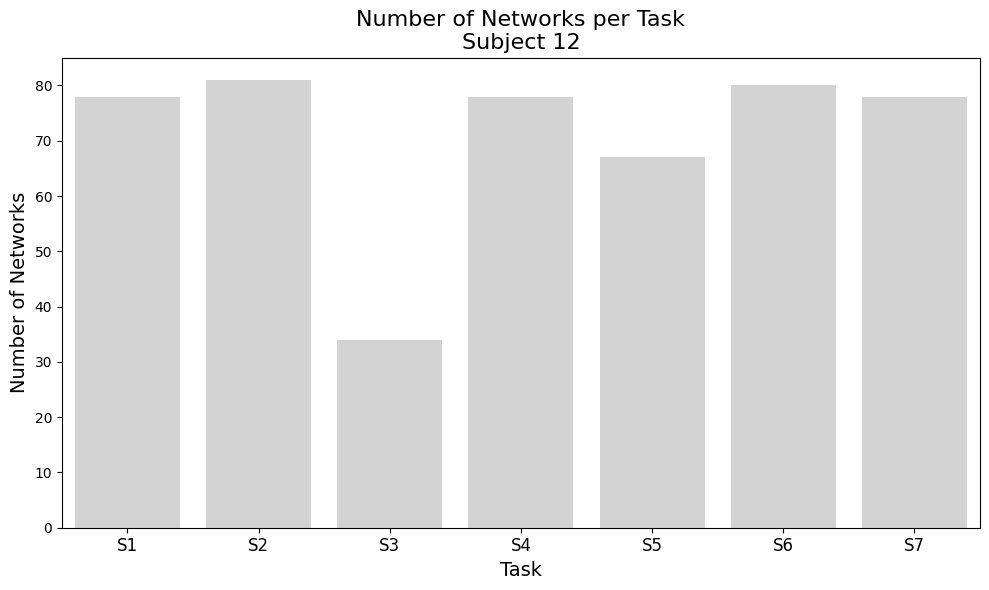

Number of networks per task:
task
S1    28
S2    11
S3    20
S4     6
S5    24
S6     7
S7     6
Name: count, dtype: int64


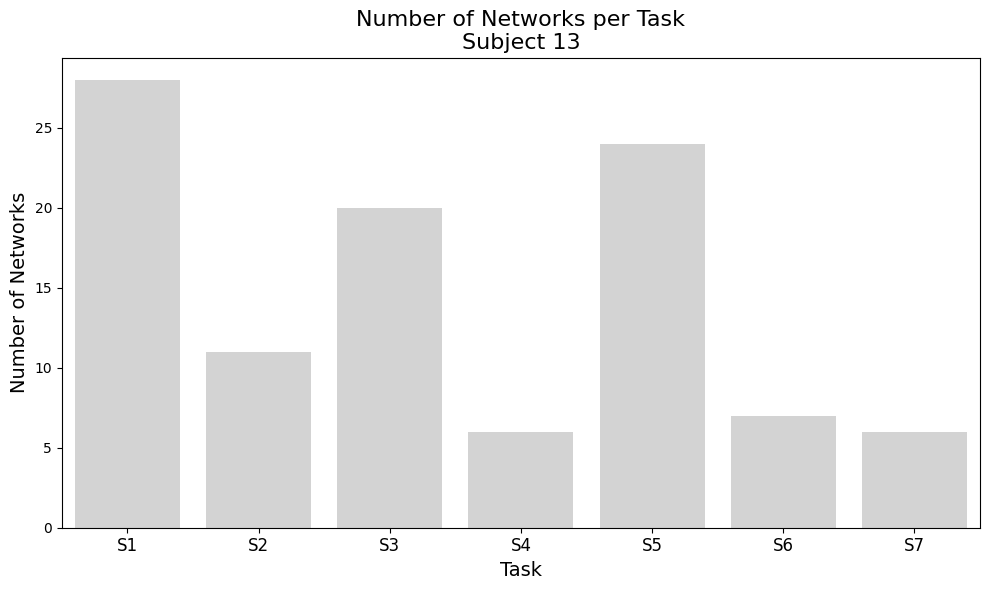

Number of networks per task:
task
S1    54
S2     7
S3     6
S4     3
S5     4
S6    11
S7    12
Name: count, dtype: int64


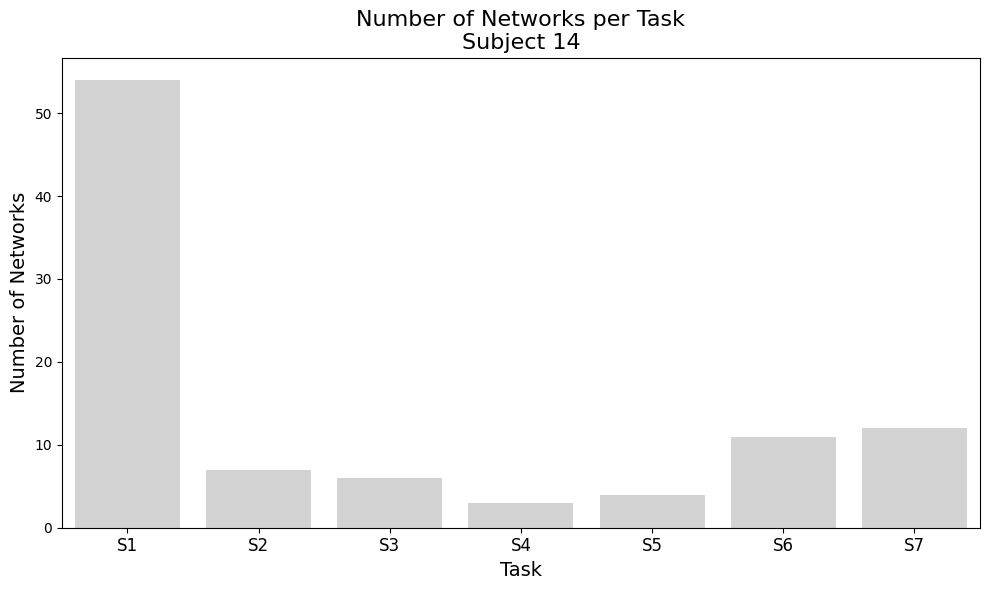

Number of networks per task:
task
S1    4
S2    1
S3    1
S4    1
S5    5
S6    4
S7    1
Name: count, dtype: int64


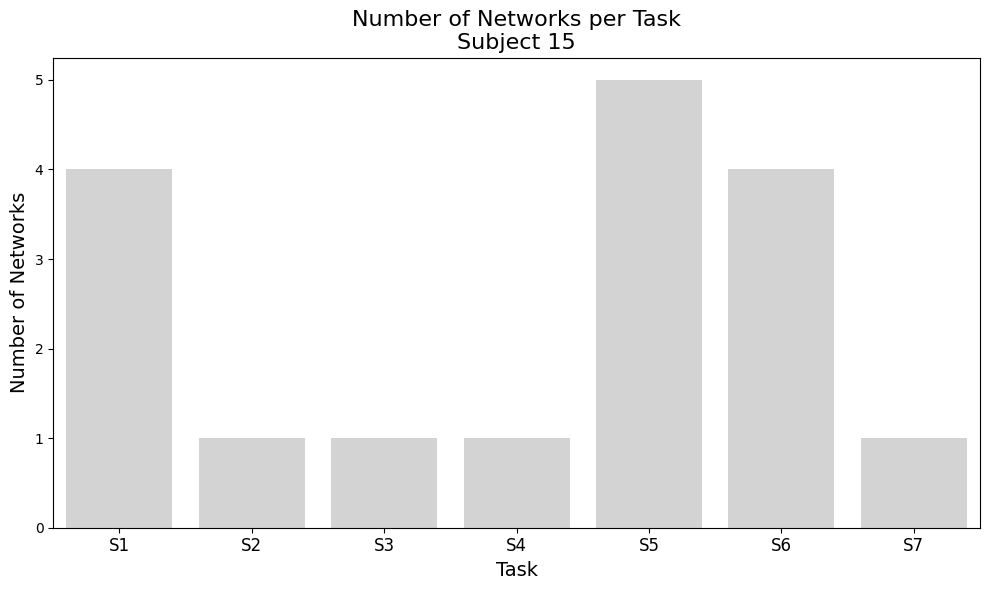

Number of networks per task:
task
S1    38
S2    43
S3    28
S4    45
S5    41
S6    36
S7    13
Name: count, dtype: int64


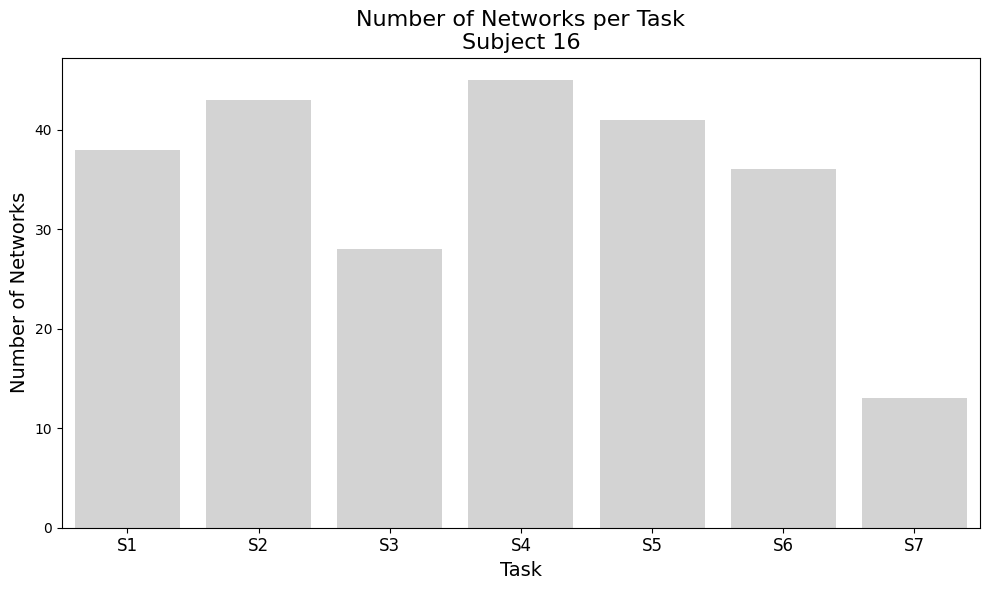

Number of networks per task:
task
S1     7
S2     6
S3     1
S4    53
S5     9
S6     3
S7    11
Name: count, dtype: int64


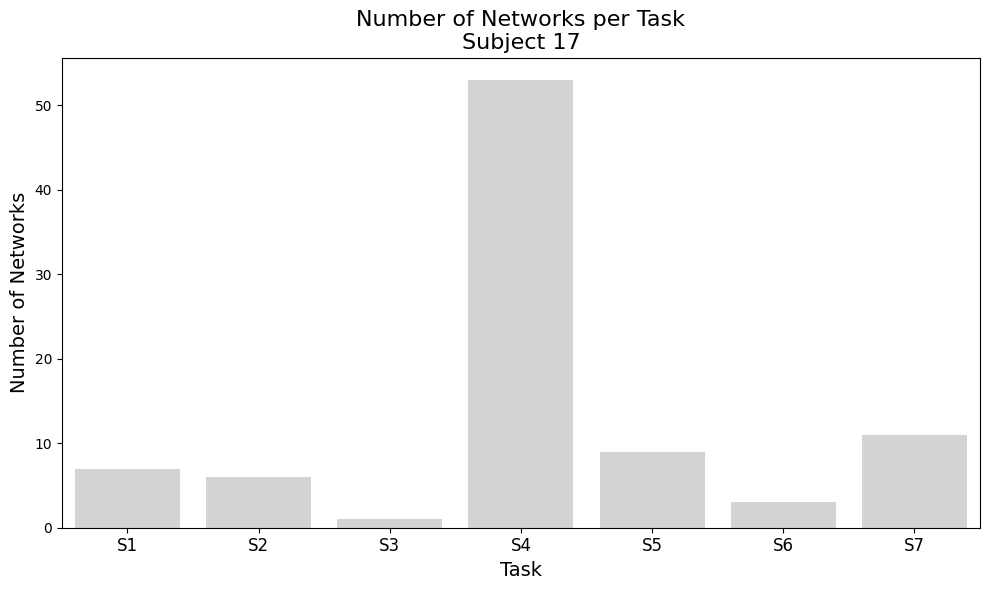

Number of networks per task:
task
S1    61
S2    63
S3    64
S4    61
S5    62
S6    63
S7    61
Name: count, dtype: int64


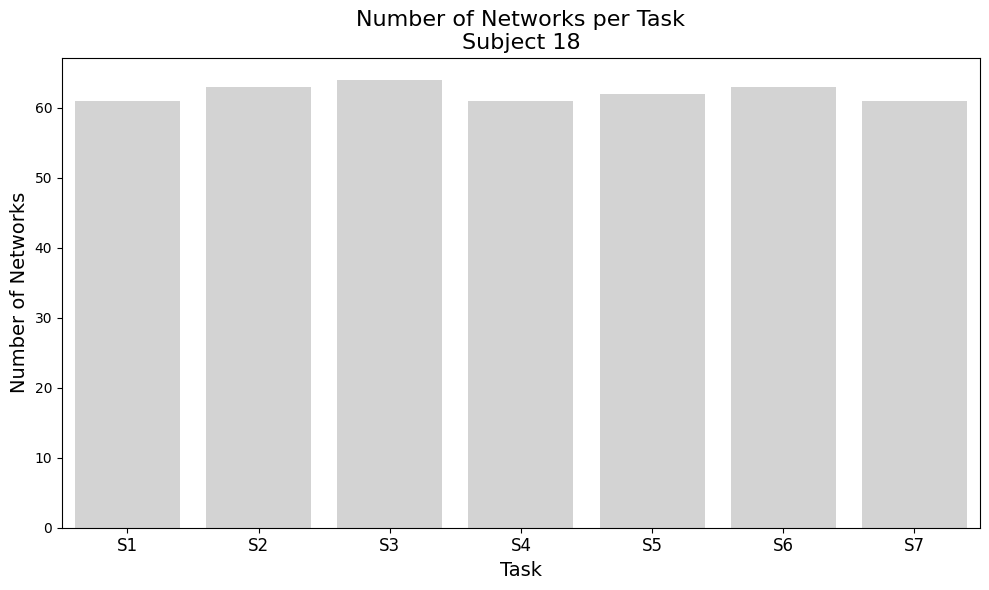

Number of networks per task:
task
S1    12
S2     2
S3    48
S4     4
S5    38
S6    27
S7     2
Name: count, dtype: int64


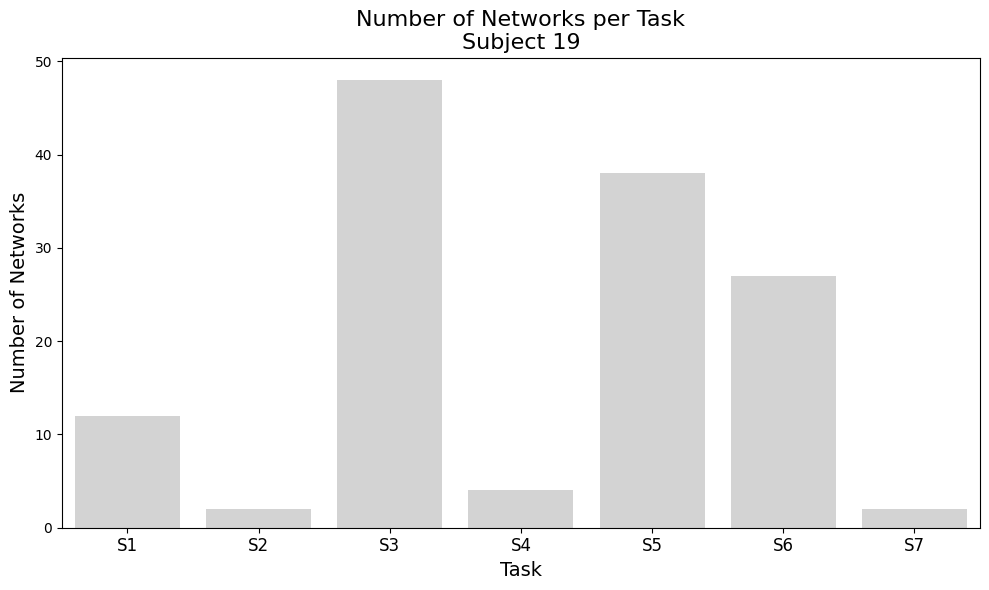

Number of networks per task:
task
S1    14
S2    22
S3    39
S4    68
S5    29
S6    43
S7    28
Name: count, dtype: int64


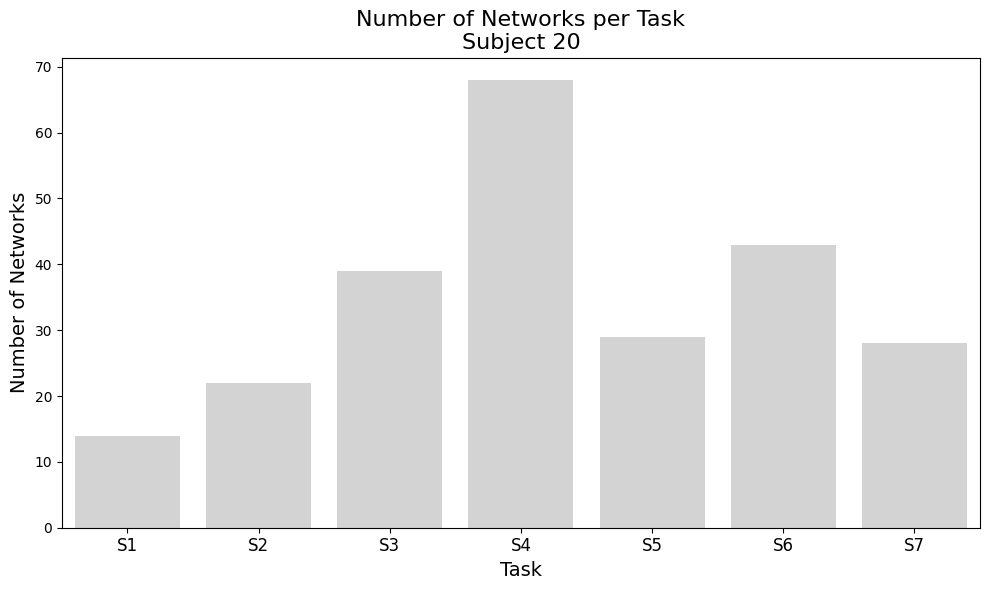

Number of networks per task:
task
S1    57
S2    54
S3     7
S4    64
S5    43
S6    16
S7     1
Name: count, dtype: int64


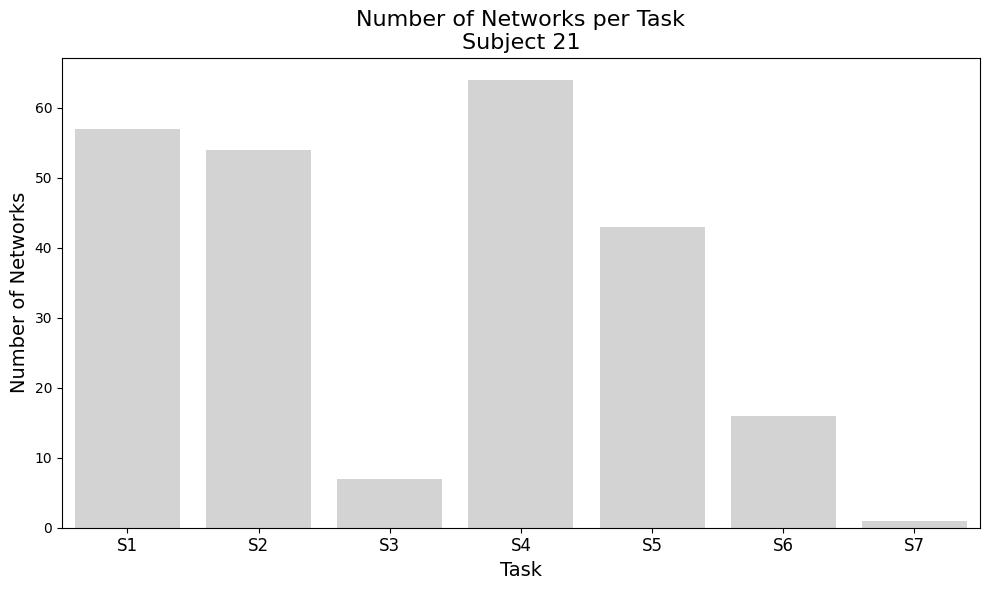

Number of networks per task:
task
S1    20
S2     8
S3     9
S4     4
S5     3
S6    50
S7    12
Name: count, dtype: int64


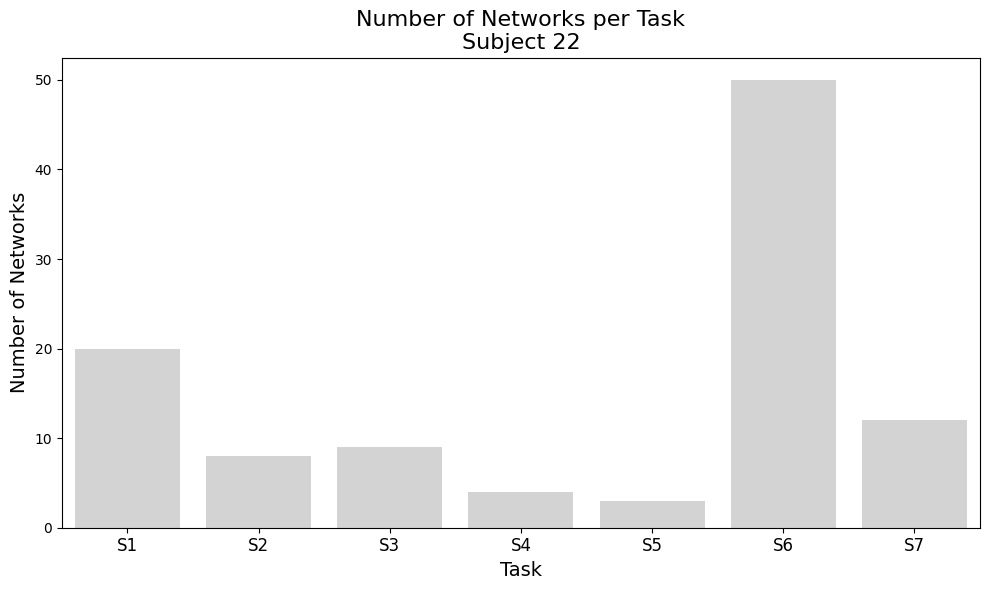

Number of networks per task:
task
S1    22
S2    32
S3    22
S4    25
S5    27
S6    32
S7    29
Name: count, dtype: int64


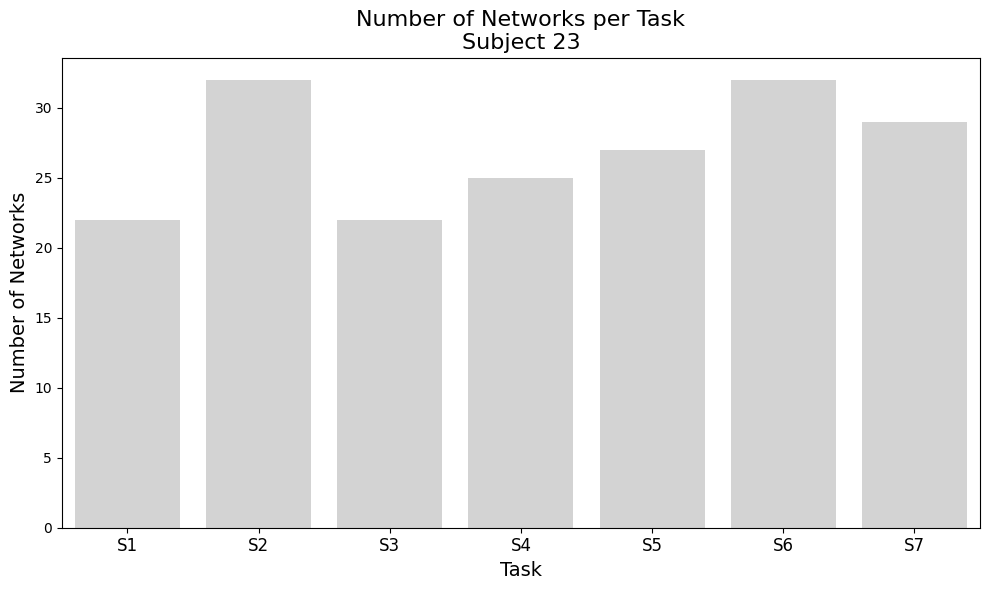

Number of networks per task:
task
S1    28
S2    23
S3    20
S4    29
S5    18
S6    23
S7    22
Name: count, dtype: int64


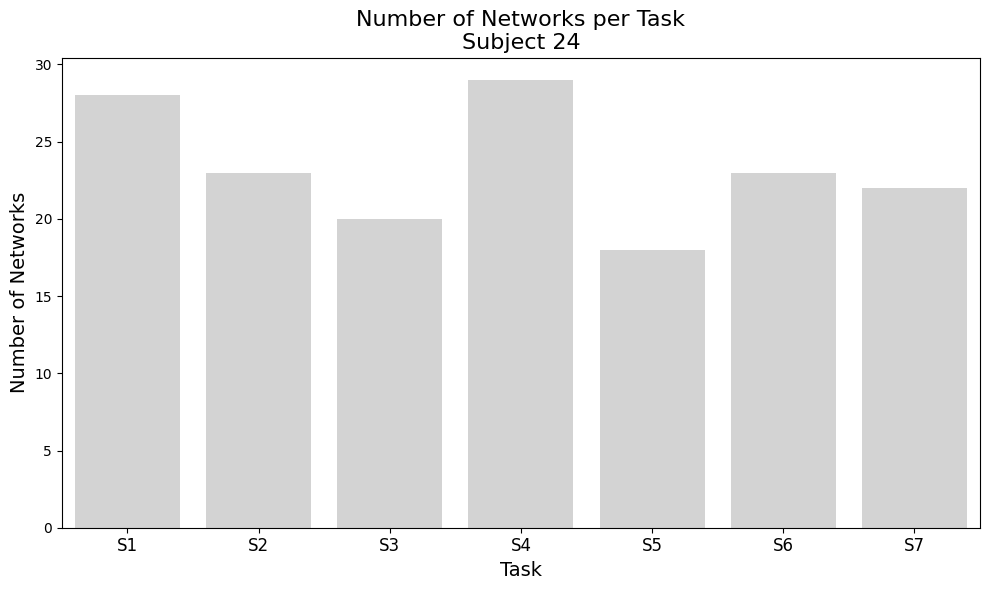

In [ ]:

from collections import Counter

for i in range(1,25):
  subject_id = f"sub{i}"
  subject_networks = [net for net in all_networks if net["subject"] == subject_id]

  # Convert list of dictionaries to DataFrame
  df = pd.DataFrame(subject_networks)

  # Count number of networks per class (task S1–S7)
  task_distribution = df['task'].value_counts().sort_index()

  # Print or visualize
  print("Number of networks per task:")
  print(task_distribution)

  # Plot boxplot of PEC values per task
  plt.figure(figsize=(10, 6))
  sns.barplot(task_distribution, color='lightgrey')
  plt.title(f"Number of Networks per Task\nSubject {i}", fontsize=16)
  plt.xlabel("Task", fontsize=14)
  plt.ylabel("Number of Networks", fontsize=14)
  plt.xticks(fontsize=12)

  plt.tight_layout()
  plt.show()




In [8]:
def load_subject(id=1, data_folder=output_folder):
    """
    Load all networks for a single subject, ensuring data exists for all tasks S1–S7.

    Parameters:
    - id (int): Subject ID to load.
    - data_folder (str): Path to folder containing the .xlsx network files.

    Returns:
    - all_networks (list of dicts): Each dict has keys: subject, task, net_nodes, pec, tags.

    Raises:
    - ValueError if any of the tasks (S1–S7) are missing.
    """
    expected_tasks = {f"S{i}" for i in range(1, 7)}
    all_networks = []
    found_tasks = set()

    pattern = re.compile(r'nets_(3down|23|12)_(S\d+)_(\d+)\.xlsx$')
    files = glob.glob(os.path.join(data_folder, f"nets_*_S*_{id}.xlsx"))

    for file in files:
        match = pattern.search(file)
        if not match:
            continue

        sigma, task, subject_id = match.groups()
        found_tasks.add(task)

        subject_id = f"subj{subject_id}"
        df = parse_subject_file(file)

        # Temp dict to collect unique networks
        net_dict = {}

        for _, row in df.iterrows():
            key = (task, subject_id, row['Net Nodes'])
            if key not in net_dict:
                net_dict[key] = {
                    'task': task,
                    'subject': subject_id,
                    'net_nodes': row['Net Nodes'],
                    'pec': row['Last PEC Value'],
                    'tags': set(row['Processing Tags']),
                }
            else:
                net_dict[key]['tags'].update(row['Processing Tags'])

        # Add unique entries to the result
        for net in net_dict.values():
            net['tags'] = sorted(net['tags'])  # optional
            all_networks.append(net)

    # Check if all required tasks are present
    missing_tasks = expected_tasks - found_tasks
    if missing_tasks:
        raise ValueError(f"Subject {id} is missing data for task(s): {', '.join(sorted(missing_tasks))}")

    return all_networks



{'task': 'S2', 'subject': 'subj4', 'net_nodes': (20, 14, 18, 0, 34, 1, 38, 41), 'pec': 0.109005934265136, 'tags': ['attention', 'auditory', 'emotion', 'executive', 'language', 'motor', 'sensorimotor', 'visual']}


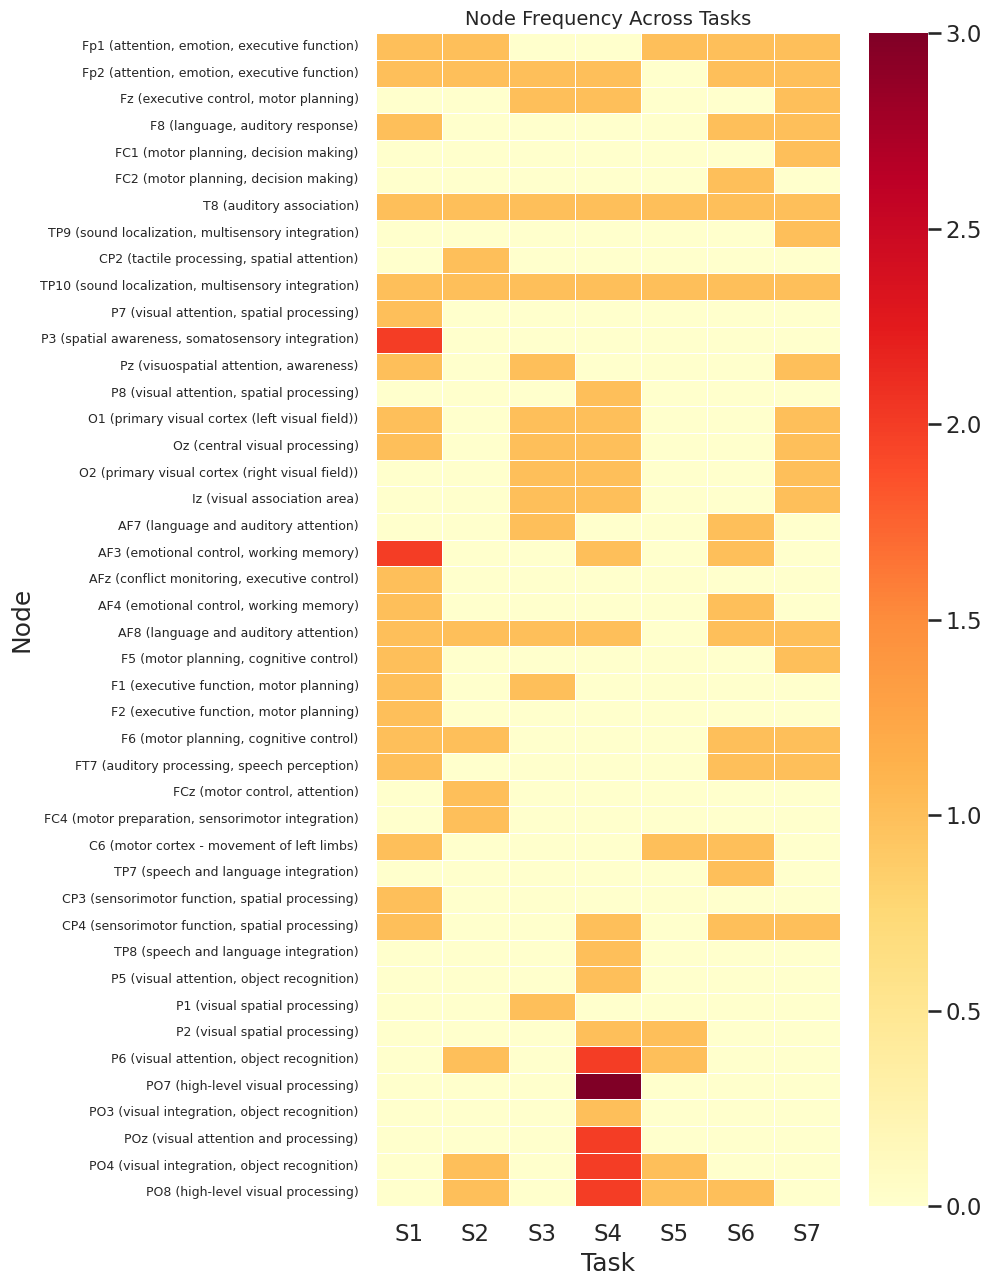

Nodes shared across all tasks: [14, 20]
  T8: (auditory association)
  TP10: (sound localization, multisensory integration)
S2 ∩ S3: [1, 14, 20, 34] (n=4)
S2 ∩ S4: [1, 14, 20, 34, 56, 60, 61] (n=7)
S2 ∩ S5: [0, 14, 20, 56, 60, 61] (n=6)
S2 ∩ S1: [0, 1, 14, 20, 34, 38] (n=6)
S2 ∩ S6: [0, 1, 14, 20, 34, 38, 61] (n=7)
S2 ∩ S7: [0, 1, 14, 20, 34, 38] (n=6)
S3 ∩ S4: [1, 4, 14, 20, 26, 27, 28, 29, 34] (n=9)
S3 ∩ S5: [14, 20] (n=2)
S3 ∩ S1: [1, 14, 20, 23, 26, 27, 34, 36] (n=8)
S3 ∩ S6: [1, 14, 20, 30, 34] (n=5)
S3 ∩ S7: [1, 4, 14, 20, 23, 26, 27, 28, 29, 34] (n=10)
S4 ∩ S5: [14, 20, 55, 56, 60, 61] (n=6)
S4 ∩ S1: [1, 14, 20, 26, 27, 31, 34, 51] (n=8)
S4 ∩ S6: [1, 14, 20, 31, 34, 51, 61] (n=7)
S4 ∩ S7: [1, 4, 14, 20, 26, 27, 28, 29, 34, 51] (n=10)
S5 ∩ S1: [0, 14, 20, 47] (n=4)
S5 ∩ S6: [0, 14, 20, 47, 61] (n=5)
S5 ∩ S7: [0, 14, 20] (n=3)
S1 ∩ S6: [0, 1, 6, 14, 20, 31, 33, 34, 38, 39, 47, 51] (n=12)
S1 ∩ S7: [0, 1, 6, 14, 20, 23, 26, 27, 34, 35, 38, 39, 51] (n=13)
S6 ∩ S7: [0, 1, 6, 14, 20, 3

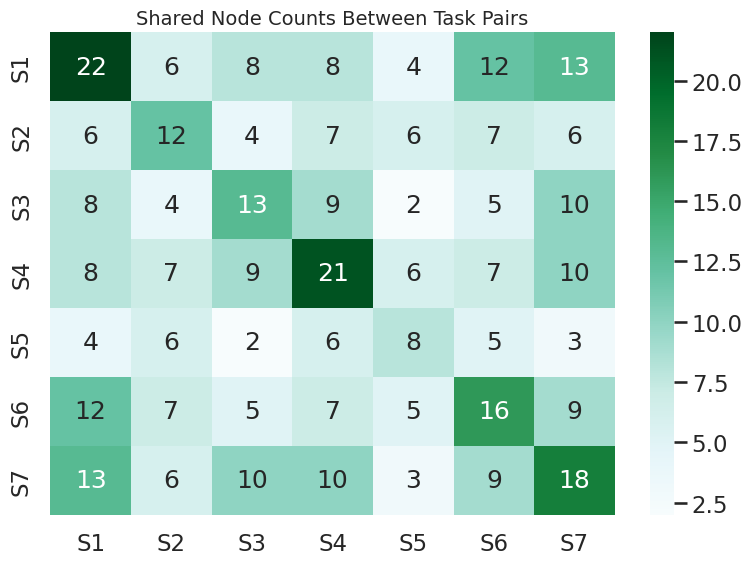

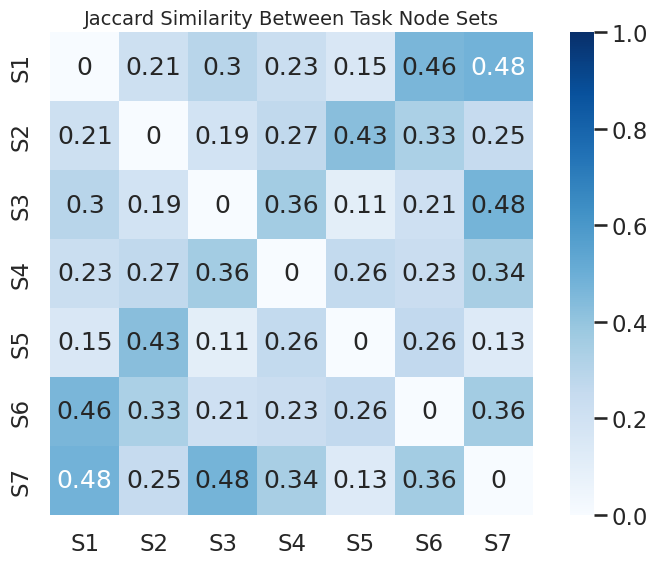


Task-Specific Nodes

Task S1 has 5 task-specific node(s)
  P7: (visual attention, spatial processing)
  P3: (spatial awareness, somatosensory integration)
  AFz: (conflict monitoring, executive control)
  F2: (executive function, motor planning)
  CP3: (sensorimotor function, spatial processing)

Task S2 has 3 task-specific node(s)
  CP2: (tactile processing, spatial attention)
  FCz: (motor control, attention)
  FC4: (motor preparation, sensorimotor integration)

Task S3 has 1 task-specific node(s)
  P1: (visual spatial processing)

Task S4 has 6 task-specific node(s)
  P8: (visual attention, spatial processing)
  TP8: (speech and language integration)
  P5: (visual attention, object recognition)
  PO7: (high-level visual processing)
  PO3: (visual integration, object recognition)
  POz: (visual attention and processing)

Task S5 has 0 task-specific node(s)

Task S6 has 2 task-specific node(s)
  FC2: (motor planning, decision making)
  TP7: (speech and language integration)

Task S7 

In [ ]:
def label_node(node_id):
    funcs = node_functions.get(node_id, [])
    return f"{channels_labels[node_id]} ({', '.join(funcs)})" if funcs else str(node_id)

sub1 = load_subject(id=4)
print(sub1[0])

# Step 1: Find the minimum pec per task
min_pec_per_task = defaultdict(lambda: float('inf'))

for net in sub1:
    task = net['task']
    pec = net['pec']
    if pec < min_pec_per_task[task]:
        min_pec_per_task[task] = pec

# Step 2: Filter sub1 to keep only nets with lowest pec per task
best_nets_sub1 = [
    net for net in sub1
    if net['pec'] == min_pec_per_task[net['task']]
]

# Step 1: Count node occurrences per task
task_node_counts = defaultdict(Counter)
task_network_counts = Counter()  # Counts number of networks per task

for net in sub1:
    task = net['task']
    nodes = net['net_nodes']
    task_node_counts[task].update(nodes)
    task_network_counts[task] += 1

# Step 2: Create frequency DataFrame (nodes × tasks)
all_nodes = sorted({node for counter in task_node_counts.values() for node in counter})
task_list = sorted(task_node_counts.keys())

freq_df = pd.DataFrame(index=all_nodes, columns=task_list).fillna(0)

for task in task_list:
    for node, count in task_node_counts[task].items():
        freq_df.at[node, task] = count

# # Normalize by number of networks per task
# for task in task_list:
#     freq_df[task] /= task_network_counts[task]

# Step 3: Plot frequency heatmap
plt.figure(figsize=(10, len(freq_df) * 0.3))
ax = sns.heatmap(freq_df, annot=False, cmap='YlOrRd', linewidths=0.5)
plt.title("Node Frequency Across Tasks", fontsize=14)
plt.xlabel("Task")
plt.ylabel("Node")

ytick_labels = [
    f"{channels_labels[node]} ({', '.join(node_functions.get(node, []))})"
    for node in freq_df.index]
ax.set_yticks(np.arange(len(freq_df)) + 0.5)
ax.set_yticklabels(ytick_labels, fontsize=9, rotation=0, va='center')

plt.tight_layout()
plt.show()

# Step 4: Shared nodes across all tasks
task_sets = {task: set(counter.keys()) for task, counter in task_node_counts.items()}
shared_across_all = set.intersection(*task_sets.values())
print(f"Nodes shared across all tasks: {sorted(shared_across_all)}")
for node in sorted(shared_across_all):
    funcs = ", ".join(node_functions.get(node, []))
    print(f"  {channels_labels[node]}: ({funcs})")

# Step 5: Pairwise shared nodes
pairwise_shared_nodes = {}

for task1, task2 in combinations(task_sets.keys(), 2):
    shared = task_sets[task1].intersection(task_sets[task2])
    pairwise_shared_nodes[(task1, task2)] = shared
    print(f"{task1} ∩ {task2}: {sorted(shared)} (n={len(shared)})")

# Step 6: Plot pairwise shared node count matrix
shared_count_matrix = pd.DataFrame(index=task_list, columns=task_list).fillna(0)

for (t1, t2), shared in pairwise_shared_nodes.items():
    shared_count = len(shared)
    shared_count_matrix.loc[t1, t2] = shared_count
    shared_count_matrix.loc[t2, t1] = shared_count

# Diagonal: total unique nodes per task
for task in task_list:
    shared_count_matrix.loc[task, task] = len(task_sets[task])

plt.figure(figsize=(8, 6))
sns.heatmap(shared_count_matrix.astype(int), annot=True, cmap="BuGn", fmt='d')
plt.title("Shared Node Counts Between Task Pairs", fontsize=14)
plt.tight_layout()
plt.show()

from sklearn.metrics import jaccard_score

jaccard_matrix = pd.DataFrame(index=task_order, columns=task_order).fillna(0)
bin_df = freq_df > 0

for t1, t2 in combinations(task_order, 2):
    score = jaccard_score(bin_df[t1], bin_df[t2])
    jaccard_matrix.loc[t1, t2] = score
    jaccard_matrix.loc[t2, t1] = score

# Convert to float for heatmap
jaccard_matrix = jaccard_matrix.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(jaccard_matrix, annot=True, cmap='Blues', vmin=0, vmax=1, square=True)
plt.title("Jaccard Similarity Between Task Node Sets", fontsize=14)
plt.tight_layout()
plt.show()


# Task-specific nodes
print("\nTask-Specific Nodes")
all_tasks = set(task_sets.keys())

# For each task, subtract union of all other tasks' nodes
for task in task_list:
    other_tasks = all_tasks - {task}
    other_nodes = set.union(*(task_sets[t] for t in other_tasks))
    task_specific = task_sets[task] - other_nodes

    print(f"\nTask {task} has {len(task_specific)} task-specific node(s)")
    for node in sorted(task_specific):
        funcs = ", ".join(node_functions.get(node, []))
        print(f"  {channels_labels[node]}: ({funcs})")


In [ ]:
import matplotlib.patches as patches

def plot_function_heatmap(df, plot_title="Function Contributions Across Networks", results_path=Path("classification_clustering_reports")):
    subject = df.index[0].split('_')[0]
    results_path.mkdir(exist_ok=True)

    # Transpose for heatmap
    data = df.T

    # Remove functions (rows) with all zeros
    data = data.loc[~(data == 0).all(axis=1)]

    # Sort functions by predefined order
    ordered_functions = [f for f in function_weights if f in data.index]
    data_plot = data.loc[ordered_functions]

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(min(0.3 * len(data_plot.columns), 40), 12))
    sns.heatmap(
        data_plot,
        cmap="mako",
        cbar_kws={'label': 'PEC-weighted score'},
        ax=ax,
        xticklabels=False,  # disable default xticks since you'll relabel
        yticklabels=True
    )

    # Increase y-axis tick font size (function names)
    ax.tick_params(axis='y', labelsize=22)

    # Parse task labels (e.g., "S1", "S2")
    task_labels = [idx.split('_')[1] for idx in df.index]

    # Track start and end positions for each task
    task_positions = {}
    for i, task in enumerate(task_labels):
        if task not in task_positions:
            task_positions[task] = [i, i]
        else:
            task_positions[task][1] = i

    # Clear default xticks
    ax.set_xticks([])

    # Map task codes to human-readable labels
    task_label_map = {
        'S1': 'A1',
        'S2': 'A2',
        'S3': 'A3',
        'S4': 'V1',
        'S5': 'V2',
        'S6': 'V3',
        'S7': 'R'
    }

    # Draw group labels under x-axis with mapped names
    for task, (start, end) in task_positions.items():
        label = task_label_map.get(task, task)
        center = (start + end) / 2
        ax.text(center + 0.5, len(data_plot.index) + 0.5, label,
                ha='center', va='top', fontsize=20, rotation=0)

        # Optional: Draw vertical line to separate task blocks
        ax.add_patch(patches.Rectangle((start, 0), end - start + 1, len(data_plot.index),
                                       linewidth=0.5, edgecolor='white', facecolor='none'))

    # Set labels and title with larger font sizes
    ax.set_xlabel("")
    ax.set_ylabel("Cognitive Functions", labelpad=18, fontsize=22)
    ax.set_title(plot_title, pad=25, fontsize=22)

    # Set colorbar label font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label("PEC-weighted score", fontsize=22, labelpad=20)


    # Save and show
    plt.tight_layout()
    plt.savefig(results_path / f"{subject}_vectors.pdf", bbox_inches='tight')
    plt.savefig(results_path / f"{subject}_vectors.png", bbox_inches='tight', dpi=300)
    plt.show()


In [9]:
def generate_function_vectors(networks, node_functions, function_weights, plot_type='heatmap'):
    # Get all cognitive functions from the keys of function_weights
    all_functions = sorted(function_weights.keys())

    # Normalize PECs across all networks
    all_pecs = [net['pec'] for net in networks]
    max_pec = max(all_pecs)
    min_pec = min(all_pecs)

    def normalize_pec(pec):
        return 1 - (pec - min_pec) / (max_pec - min_pec + 1e-6)

    data = []
    ids = []
    s, i = 1, 0
    for net in networks:
        # Initialize a zero vector for all functions
        vector = dict.fromkeys(all_functions, 0.0)

        # Normalize this network's PEC
        pec_weight = normalize_pec(net['pec'])

        # Add PEC weight for all functions found in the network's nodes
        for node in net['net_nodes']:
            funcs = node_functions.get(node, [])
            for f in funcs:
                if f in vector:
                    vector[f] += pec_weight

        vec = [vector[f] for f in all_functions]
        data.append(vec)

        # Generate unique ID
        if f"{net['subject']}" != f"subj{s}":
            s += 1
            i = 0
        else:
            i += 1
        ids.append(f"{net['subject']}_{net['task']}_{i}")

    df = pd.DataFrame(data, columns=all_functions, index=ids)

    if plot_type == 'bar':
        avg_weights = df.mean().sort_values(ascending=False)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=avg_weights.values, y=avg_weights.index, palette="viridis")
        plt.title("Average PEC-weighted Function Contributions")
        plt.xlabel("Weighted Importance")
        plt.tight_layout()
        plt.show()

    elif plot_type == 'heatmap':

        # Sort columns (functions) by mean importance (descending)
        df_plot = df.drop(columns=['other'], errors='ignore')
        sorted_columns = df_plot.mean(axis=0).sort_values(ascending=False).index.tolist()

        # Sort rows by subject and task and repetition
        sorted_index = sorted(df_plot.index, key=lambda x: (x.split('_')[1], x.split('_')[0], int(x.split('_')[2])))

        df_sorted = df_plot.loc[sorted_index, sorted_columns]

        plot_function_heatmap(df_sorted)

    return df


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, accuracy_score,
    precision_score, recall_score, roc_auc_score, average_precision_score)

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', context='talk')

def preprocess_data(X, y_raw):
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    y_classes = le.classes_
    class_counts = pd.Series(y_raw).value_counts()
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled, y, y_classes, class_counts

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, accuracy_score,
    precision_score, recall_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

sns.set(style='whitegrid', context='talk')


def preprocess_data(X, y_raw):
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    y_classes = le.classes_
    class_counts = pd.Series(y_raw).value_counts()
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled, y, y_classes, class_counts


def evaluate_classifier(X, y, class_names, subject_id="subject", n_splits=5, plot=True, output_dir="results"):
    os.makedirs(output_dir, exist_ok=True)

    from sklearn.exceptions import NotFittedError

    class_counts = pd.Series(y).value_counts()
    valid_classes = class_counts[class_counts >= n_splits].index.tolist()

    if len(valid_classes) < 2:
        raise ValueError("Not enough valid classes for classification after filtering.")

    valid_mask = np.isin(y, valid_classes)
    X = X[valid_mask]
    y = y[valid_mask]
    label_map = {old: new for new, old in enumerate(sorted(valid_classes))}
    y = np.array([label_map[yi] for yi in y])
    class_names = [class_names[i] for i in sorted(valid_classes)]

    print(f"Including classes: {class_names}")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    clf = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)

    all_y_true, all_y_pred, all_y_proba = [], [], []
    cm_total = np.zeros((len(class_names), len(class_names)))
    all_coefs = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)

        try:
            coefs = clf.coef_
            all_coefs.append(coefs)
        except NotFittedError:
            print("Model not fitted, skipping coefficients.")

        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_proba)
        cm_total += confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))

    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    # Metric Computation
    y_true_bin = label_binarize(all_y_true, classes=np.arange(len(class_names)))

    # Scores
    report = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
    f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    acc = accuracy_score(all_y_true, all_y_pred)
    precision = precision_score(all_y_true, all_y_pred, average='weighted')
    recall = recall_score(all_y_true, all_y_pred, average='weighted')
    roc_auc_macro = roc_auc_score(y_true_bin, all_y_proba, average='macro', multi_class='ovr')
    roc_auc_weighted = roc_auc_score(y_true_bin, all_y_proba, average='weighted', multi_class='ovr')
    pr_auc_macro = average_precision_score(y_true_bin, all_y_proba, average='macro')
    pr_auc_weighted = average_precision_score(y_true_bin, all_y_proba, average='weighted')

    # Per-class ROC AUC and PR AUC
    roc_auc_per_class = {}
    pr_auc_per_class = {}

    for i, class_name in enumerate(class_names):
        roc_auc_per_class[class_name] = roc_auc_score(y_true_bin[:, i], all_y_proba[:, i])
        pr_auc_per_class[class_name] = average_precision_score(y_true_bin[:, i], all_y_proba[:, i])

    # Append to report
    metrics_df = pd.DataFrame(report).transpose()
    metrics_df['support'] = metrics_df['support'].astype(int)

    for class_name in class_names:
        metrics_df.loc[class_name, 'roc_auc'] = roc_auc_per_class[class_name]
        metrics_df.loc[class_name, 'pr_auc'] = pr_auc_per_class[class_name]

    metrics_df.loc['weighted avg', 'roc_auc'] = roc_auc_weighted
    metrics_df.loc['weighted avg', 'pr_auc'] = pr_auc_weighted

    # Plotting Curves
    if plot:
        # ROC Curve
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_y_proba[:, i])
            plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc_per_class[class_name]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"Subject #{subject_id} ROC Curves")
        plt.legend(loc='lower right', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{subject_id}_roc_curves.pdf"))
        plt.show()

        # PR Curve
        plt.figure(figsize=(8, 6))
        for i, class_name in enumerate(class_names):
            precision_i, recall_i, _ = precision_recall_curve(y_true_bin[:, i], all_y_proba[:, i])
            plt.plot(recall_i, precision_i, lw=2, label=f"{class_name} (AP = {pr_auc_per_class[class_name]:.2f})")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f"Subject #{subject_id} Precision-Recall Curves")
        plt.legend(loc='upper right', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{subject_id}_pr_curves.pdf"))
        plt.show()

    # Feature Importance (mean coef)
    if len(all_coefs) > 0:
        all_coefs = np.array(all_coefs)
        if all_coefs.ndim == 3:
            avg_importance = np.mean(np.abs(all_coefs), axis=(0, 1))
        else:
            avg_importance = np.mean(np.abs(all_coefs), axis=0)
    else:
        avg_importance = np.zeros(X.shape[1])
        print("Warning: No coefficients collected.")

    return (
        metrics_df, cm_total, f1, acc, precision, recall,
        roc_auc_weighted, pr_auc_weighted,
        class_names, avg_importance
    )


In [ ]:
output_dir = project_root/"data/results/cnn/"

import builtins

min = builtins.min
max = builtins.max

feature_importances = []

for subject_id in range(1,25):
    print(f"\nProcessing Subject {subject_id}")
    try:
        # Load subject data
        subject_data = load_subject(id=subject_id)
        df_vectors = generate_function_vectors(subject_data, node_functions, function_weights, plot_type='heatmap')
        # Preprocess
        X = df_vectors.values
        y_raw = [idx.split('_')[1] for idx in df_vectors.index]
        X_scaled, y, y_classes, class_counts = preprocess_data(X, y_raw)

        if len(np.unique(y)) < 2:
            print(f"Subject {subject_id}: Less than 2 classes present. Skipping.")
            continue
        # Classify
        metrics_df, cm_total, f1, acc, prec, rec, roc_auc, pr_auc, class_names, importances = evaluate_classifier(X_scaled, y, y_classes, subject_id=subject_id, plot=False)

        feature_importances.append(importances)

        metrics_df.to_csv(output_dir / f"subject_{subject_id}_classification_metrics.csv")
        pd.DataFrame(cm_total, index=class_names, columns=class_names).to_csv(
            output_dir / f"subject_{subject_id}_confusion_matrix.csv"
        )

    except Exception as e:
        print(f"Subject {subject_id} failed: {e}")
        continue


Processing Subject 1
Including classes: [np.str_('S1'), np.str_('S2'), np.str_('S3'), np.str_('S4'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 2
Including classes: [np.str_('S1'), np.str_('S2'), np.str_('S3'), np.str_('S4'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 3
Including classes: [np.str_('S3'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 4
Subject 4 failed: Not enough valid classes for classification after filtering.

Processing Subject 5
Including classes: [np.str_('S2'), np.str_('S3'), np.str_('S4'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 6
Including classes: [np.str_('S1'), np.str_('S2'), np.str_('S3'), np.str_('S4'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 7
Including classes: [np.str_('S3'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 8
Including classes: [np.str_('S1'), np.str_('S2'), np.str_('S3'), np.str_('S4'), np.str_('S5'), np.st

In [ ]:
def group_labels(y_raw):
    mapping = {
        'S1': 'audio', 'S2': 'audio', 'S3': 'audio',
        'S4': 'video', 'S5': 'video', 'S6': 'video',
        'S7': 'rest'
    }
    y_grouped = [mapping[label] for label in y_raw]
    return y_grouped

import builtins
min = builtins.min
max = builtins.max

feature_importances = []

for subject_id in range(1,25):
    print(f"\nProcessing Subject {subject_id}")
    try:
        # Load subject data
        subject_data = load_subject(id=subject_id)
        df_vectors = generate_function_vectors(subject_data, node_functions, function_weights, plot_type='heatmap')
        # Preprocess
        X = df_vectors.values
        y_raw = [idx.split('_')[1] for idx in df_vectors.index]

        # Group the original labels into 3 classes
        y_grouped = group_labels(y_raw)

        # Preprocess with grouped labels
        X_scaled, y, y_classes, class_counts = preprocess_data(X, y_grouped)


        if len(np.unique(y)) < 2:
            print(f"Subject {subject_id}: Less than 2 classes present. Skipping.")
            continue
        # Classify
        metrics_df, cm_total, f1, acc, prec, rec, roc_auc, pr_auc, class_names, importances = evaluate_classifier(X_scaled, y, y_classes, subject_id=subject_id, plot=False)

        feature_importances.append(importances)

        metrics_df.to_csv(output_dir / f"subject_{subject_id}_classification_metrics.csv")
        pd.DataFrame(cm_total, index=class_names, columns=class_names).to_csv(
            output_dir / f"subject_{subject_id}_confusion_matrix.csv"
        )

    except Exception as e:
        print(f"Subject {subject_id} failed: {e}")
        continue


Output hidden; open in https://colab.research.google.com to view.

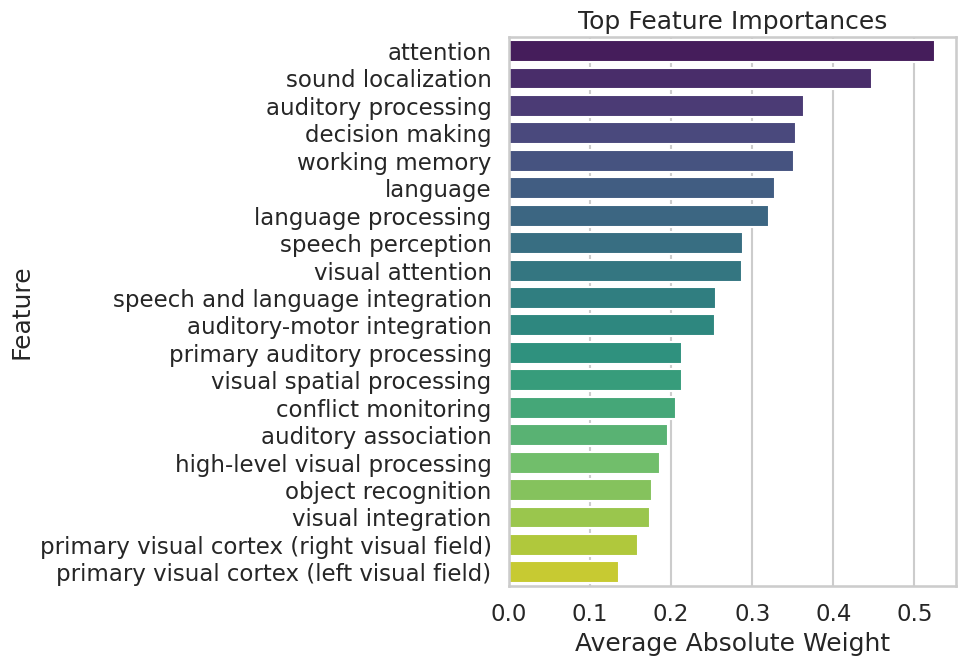

In [ ]:
def plot_top_features(avg_importance, feature_names=None, top_n=20, title="Top Feature Importances", save_path=None):
    """
    Plot the top N most important features from averaged SVM coefficients.

    Parameters:
    - avg_importance (array-like): Importance values (e.g., mean of abs(coef_)).
    - feature_names (list or None): List of actual feature labels. If None, uses F0, F1, ...
    - top_n (int): Number of top features to show.
    - title (str): Plot title.
    - save_path (str or None): If provided, saves the figure to this path.
    """
    # Default to generic feature labels if not provided
    if feature_names is None:
        feature_names = [f"F{i}" for i in range(len(avg_importance))]

    if len(feature_names) != len(avg_importance):
        raise ValueError("Length of feature_names must match length of avg_importance.")

    # Create a DataFrame for easier sorting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': avg_importance
    })

    # Select top N features by importance
    top_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 7))
    sns.barplot(data=top_df, x='Importance', y='Feature', palette='viridis')
    plt.title(title)
    plt.xlabel('Average Absolute Weight')
    plt.ylabel('Feature')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


feature_labels = df_vectors.columns.tolist()

mean_importance = np.mean(feature_importances, axis=0)
plot_top_features(mean_importance, feature_names=feature_labels, top_n=20, save_path=os.path.join(output_dir, "feature_importances.pdf"))



precision normality p-values per class: [('S1', np.float64(0.09049958155326437)), ('S2', np.float64(0.015253486758553396)), ('S3', np.float64(0.0709752782228061)), ('S4', np.float64(0.649018429811639)), ('S5', np.float64(0.07613216011263832)), ('S6', np.float64(0.11281880398371696)), ('S7', np.float64(0.704998040637866))]
Levene test p-value: 0.8038
precision: Using Mann-Whitney U tests

recall normality p-values per class: [('S1', np.float64(0.35328045769554073)), ('S2', np.float64(0.23575041877463193)), ('S3', np.float64(0.31386211851293877)), ('S4', np.float64(0.4041197162720361)), ('S5', np.float64(0.09854459726086381)), ('S6', np.float64(0.12754965776370264)), ('S7', np.float64(0.19636345805679445))]
Levene test p-value: 0.2766
recall: Using ANOVA + Tukey
ANOVA p-value: 0.0159

f1-score normality p-values per class: [('S1', np.float64(0.48209033597003725)), ('S2', np.float64(0.28011958845987833)), ('S3', np.float64(0.4044308549494725)), ('S4', np.float64(0.7266617944882969)), ('S

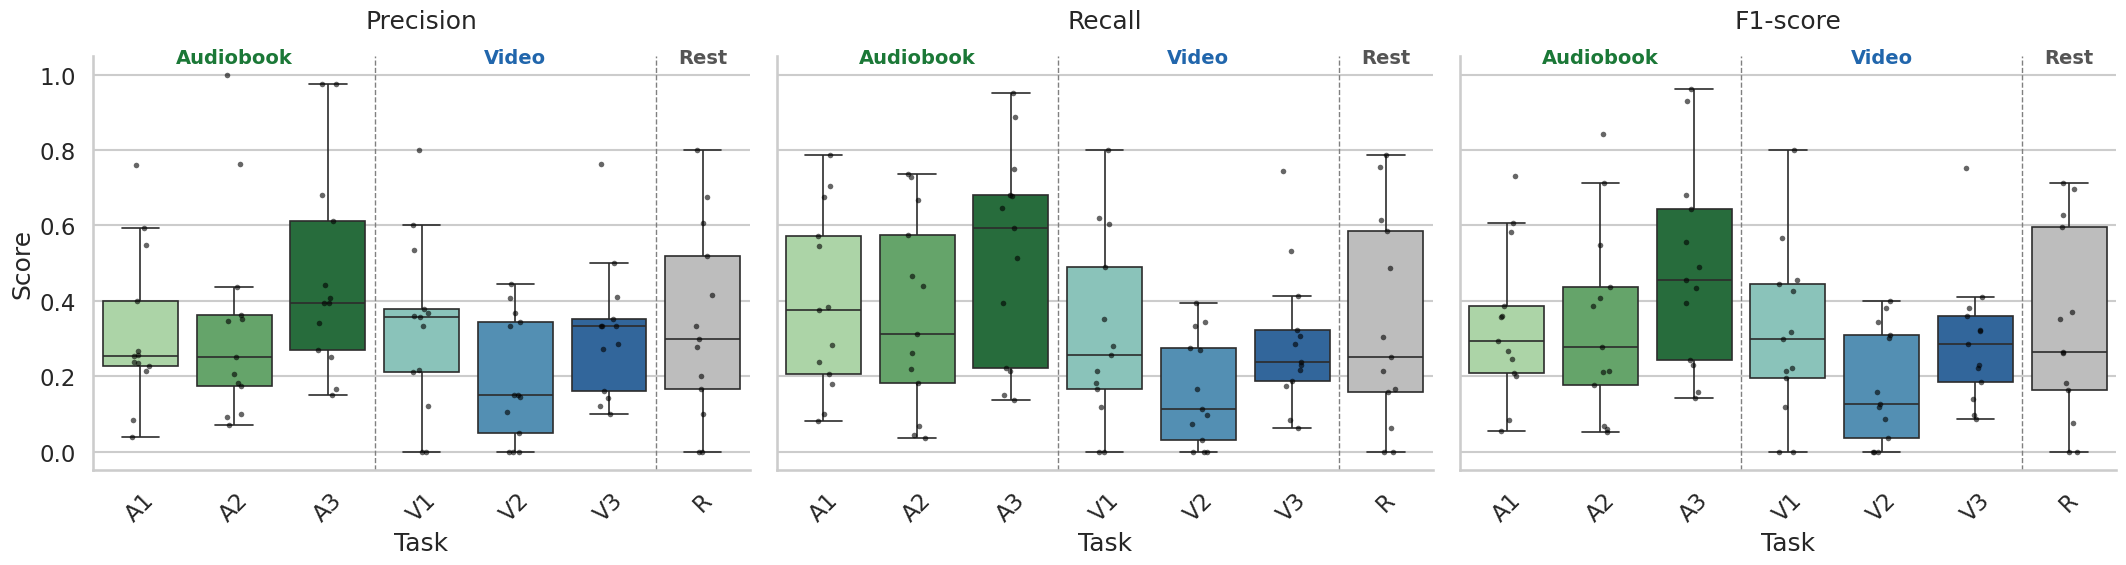


=== Per-Class Boxplot Stats ===
   Metric Class      min   median      max Task
 f1-score    S1 0.055556 0.294118 0.730769   A1
 f1-score    S2 0.052632 0.277778 0.842105   A2
 f1-score    S3 0.142857 0.454545 0.962656   A3
 f1-score    S4 0.000000 0.298507 0.800000   V1
 f1-score    S5 0.000000 0.127273 0.400000   V2
 f1-score    S6 0.086957 0.285714 0.752941   V3
 f1-score    S7 0.000000 0.263158 0.713178    R
precision    S1 0.038462 0.252874 0.760000   A1
precision    S2 0.071429 0.250000 1.000000   A2
precision    S3 0.150000 0.392857 0.975610   A3
precision    S4 0.000000 0.357143 0.800000   V1
precision    S5 0.000000 0.150000 0.444444   V2
precision    S6 0.100000 0.333333 0.761905   V3
precision    S7 0.000000 0.299213 0.800000    R
   recall    S1 0.081967 0.375000 0.785714   A1
   recall    S2 0.037037 0.312500 0.736842   A2
   recall    S3 0.136364 0.593750 0.950820   A3
   recall    S4 0.000000 0.256410 0.800000   V1
   recall    S5 0.000000 0.112903 0.392857   V2
   reca

In [ ]:
from scipy.stats import shapiro, levene, f_oneway, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Paths and settings
metrics_files = sorted(glob.glob(os.path.join(output_dir, "subject_*_metrics.csv")))

ordered_classes = [f'S{i}' for i in range(1, 8)]
task_labels = {
    'S1': 'A1',
    'S2': 'A2',
    'S3': 'A3',
    'S4': 'V1',
    'S5': 'V2',
    'S6': 'V3',
    'S7': 'R'
}
custom_palette = {
    'S1': '#a6dba0',
    'S2': '#5aae61',
    'S3': '#1b7837',
    'S4': '#80cdc1',
    'S5': '#4393c3',
    'S6': '#2166ac',
    'S7': '#bdbdbd'
}

# Load and filter data: only keep files with all classes S1-S7
all_metrics = []
for m_file in metrics_files:
    df = pd.read_csv(m_file, index_col=0)
    df = df.loc[~df.index.str.contains('avg|accuracy', case=False)]
    present_classes = set(df.index.tolist())
    if all(cls in present_classes for cls in ordered_classes):
        all_metrics.append(df)

# Combine and reshape data
df_all_metrics = pd.concat(all_metrics)
df_melted = df_all_metrics.reset_index().melt(
    id_vars='index',
    value_vars=['precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)
df_melted.rename(columns={'index': 'Class'}, inplace=True)
df_melted['Task'] = df_melted['Class'].map(task_labels)
df_melted['Color'] = df_melted['Class'].map(custom_palette)

# Plot setup
sns.set(style='whitegrid', context='talk')
g = sns.catplot(
    data=df_melted, kind='box',
    x='Class', y='Score', col='Metric',
    col_order=['precision', 'recall', 'f1-score'],
    order=ordered_classes,
    sharey=True, sharex=True,
    height=6, aspect=1.2,
    palette=custom_palette,
    linewidth=1.2,
    dodge=False,
    showfliers=False
)

# Add jittered points, vertical lines, group titles, and labels
for ax, metric in zip(g.axes[0], ['precision', 'recall', 'f1-score']):
    subset = df_melted[df_melted['Metric'] == metric]

    sns.stripplot(
        data=subset, x='Class', y='Score', order=ordered_classes,
        color='black', size=4, jitter=True, alpha=0.6, ax=ax
    )

    # Vertical group divider lines
    ax.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
    ax.axvline(x=5.5, color='gray', linestyle='--', linewidth=1)

    # Group titles
    ax.text(1, 1.03, 'Audiobook', ha='center', fontsize=14, color='#1b7837', weight='bold')
    ax.text(4, 1.03, 'Video', ha='center', fontsize=14, color='#2166ac', weight='bold')
    ax.text(6, 1.03, 'Rest', ha='center', fontsize=14, color='#555555', weight='bold')

    ax.set_title(f'{metric.capitalize()}', pad=20)
    ax.set_xlabel('Task')
    ax.set_ylabel('Score')
    ax.set_xticklabels([task_labels[c] for c in ordered_classes], rotation=45)

# Function to convert p-values to stars
def pval_to_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''

# Statistical testing & annotation
for ax, metric in zip(g.axes[0], ['precision', 'recall', 'f1-score']):
    subset = df_melted[df_melted['Metric'] == metric]
    groups = [subset[subset['Class'] == cls]['Score'].values for cls in ordered_classes]

    # Check normality per group (Shapiro-Wilk)
    normality_pvals = [shapiro(g)[1] if len(g) >= 3 else 1 for g in groups]
    # Check homogeneity of variances (Levene)
    lev_stat, lev_p = levene(*groups)

    print(f"\n{metric} normality p-values per class:", list(zip(ordered_classes, normality_pvals)))
    print(f"Levene test p-value: {lev_p:.4f}")

    if all(p > 0.05 for p in normality_pvals) and lev_p > 0.05:
        print(f"{metric}: Using ANOVA + Tukey")
        anova_stat, anova_p = f_oneway(*groups)
        print(f"ANOVA p-value: {anova_p:.4f}")
        sig_pairs = []
        if anova_p <= 0.05:
            tukey = pairwise_tukeyhsd(endog=subset['Score'], groups=subset['Class'], alpha=0.05)
            for res in tukey.summary()[1:]:
                g1 = str(res[0]).strip()
                g2 = str(res[1]).strip()
                p_adj = float(str(res[4]).strip())
                reject = str(res[5]).strip() == 'True'
                if reject:
                    i = ordered_classes.index(g1)
                    j = ordered_classes.index(g2)
                    sig_pairs.append((i, j, p_adj))

    else:
        print(f"{metric}: Using Mann-Whitney U tests")
        sig_pairs = []
        for i in range(len(ordered_classes)):
            for j in range(i + 1, len(ordered_classes)):
                c1, c2 = ordered_classes[i], ordered_classes[j]
                group1 = subset[subset['Class'] == c1]['Score'].values
                group2 = subset[subset['Class'] == c2]['Score'].values
                stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
                if p < 0.05:
                    sig_pairs.append((i, j, p))

    # Annotate significant pairs on plot
    # y_max = subset['Score'].max()
    # h = 0.04  # height of bar
    # text_offset = 0.01
    # for i, j, p in sig_pairs:
    #     y = y_max + h * (j - i) + text_offset
    #     ax.plot([i, i, j, j], [y, y + h, y + h, y], c='k', lw=1.2)
    #     ax.text((i + j) / 2, y + h, pval_to_stars(p), ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "per_class_boxplots_annotated.png"), dpi=300, bbox_inches='tight')
plt.show()

# Print min, median, and max for each Class & Metric
summary_stats = (
    df_melted
    .groupby(['Metric', 'Class'])['Score']
    .agg(['min', 'median', 'max'])
    .reset_index()
)

# Map class codes to task labels for readability
summary_stats['Task'] = summary_stats['Class'].map(task_labels)

print("\n=== Per-Class Boxplot Stats ===")
print(summary_stats.to_string(index=False))


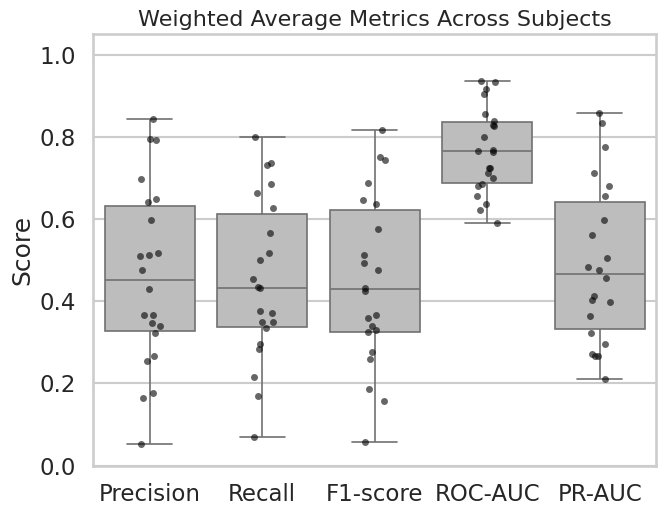

Average weighted metrics across subjects:

Precision: 0.4604
  Recall: 0.4534
F1-score: 0.4482
 ROC-AUC: 0.7674
  PR-AUC: 0.4915
Score range across subjects:

Precision: 0.0536, 0.8449
  Recall: 0.0708, 0.8012
F1-score: 0.0579, 0.8177
 ROC-AUC: 0.5915, 0.9375
  PR-AUC: 0.2104, 0.8576


In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics_files = sorted(glob.glob(os.path.join(output_dir, "subject_*_metrics.csv")))

# Collect weighted average metrics
weighted_avgs = []

for m_file in metrics_files:
    df = pd.read_csv(m_file, index_col=0)
    if 'weighted avg' in df.index:
        row = df.loc['weighted avg']
        weighted_avgs.append({
            'Subject': os.path.basename(m_file).split("_")[1],
            'Precision': row.get('precision', None),
            'Recall': row.get('recall', None),
            'F1-score': row.get('f1-score', None),
            'ROC-AUC': row.get('roc_auc', None),
            'PR-AUC': row.get('pr_auc', None)
        })

df_weighted = pd.DataFrame(weighted_avgs)

# Melt to long format for seaborn
df_weighted_long = df_weighted.melt(id_vars='Subject', var_name='Metric', value_name='Score')

# Plot all metrics together
plt.figure(figsize=(7, 5.5))
sns.boxplot(data=df_weighted_long, x='Metric', y='Score', linewidth=1.2, color='#bdbdbd')
sns.stripplot(data=df_weighted_long, x='Metric', y='Score', color='black', size=5, jitter=True, alpha=0.6)

plt.title('Weighted Average Metrics Across Subjects', fontsize=16)
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "combined_weighted_metrics_boxplot.png"), dpi=300, bbox_inches='tight')
plt.show()

# Compute and print average and score range across subjects
mean_scores = df_weighted.drop(columns='Subject').mean()
print("Average weighted metrics across subjects:\n")
for metric, score in mean_scores.items():
    print(f"{metric:>8}: {score:.4f}")

max_scores = df_weighted.drop(columns='Subject').max()
min_scores = df_weighted.drop(columns='Subject').min()
print("Score range across subjects:\n")
for imin, imax in zip(min_scores.items(), max_scores.items()):
    print(f"{imin[0]:>8}: {imin[1]:.4f}, {imax[1]:.4f}")

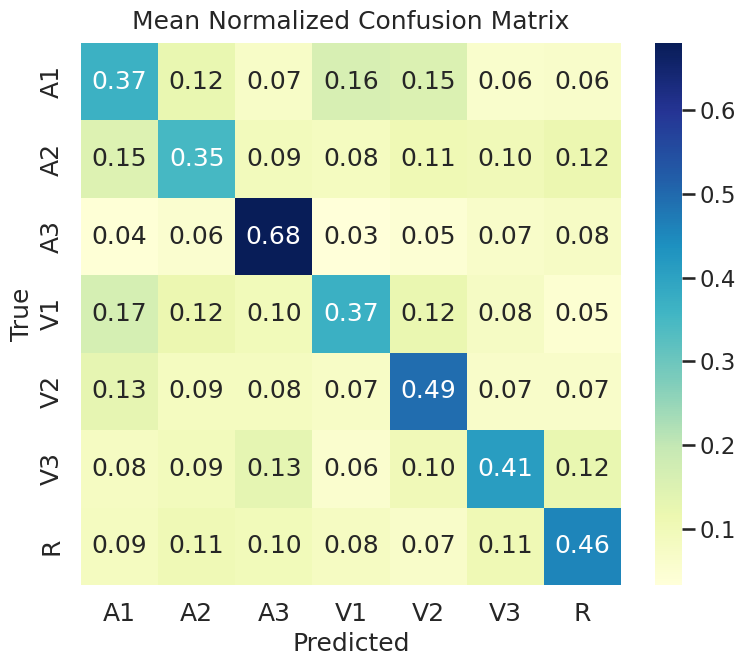


Top 10 Most Confused Class Pairs Across Subjects:

S4  S1    0.165846
S1  S4    0.161634
    S5    0.152753
S2  S1    0.149281
S6  S3    0.134006
S5  S1    0.129977
S6  S7    0.123919
S1  S2    0.122558
S4  S5    0.121511
    S2    0.118227
dtype: float64


In [ ]:
import matplotlib.patches as mpatches

task_labels = {
    'S1': 'A1',
    'S2': 'A2',
    'S3': 'A3',
    'S4': 'V1',
    'S5': 'V2',
    'S6': 'V3',
    'S7': 'R'
}

# Set paths
metrics_files = sorted(glob.glob(os.path.join(output_dir, "subject_*_metrics.csv")))
conf_matrix_files = sorted(glob.glob(os.path.join(output_dir, "subject_*_confusion_matrix.csv")))

all_metrics = []
all_conf_matrices = []
class_names = None

# Load data
for m_file, c_file in zip(metrics_files, conf_matrix_files):
    df_metrics = pd.read_csv(m_file, index_col=0)
    df_metrics = df_metrics.loc[~df_metrics.index.str.contains('avg|accuracy', case=False)]
    all_metrics.append(df_metrics)

    if class_names is None:
        class_names = df_metrics.index.tolist()

    cm = pd.read_csv(c_file, index_col=0).values
    all_conf_matrices.append(cm)

# Determine full class list
all_classes = sorted(set(cls for df in all_metrics for cls in df.index))
n_classes = len(all_classes)
class_to_index = {cls: i for i, cls in enumerate(all_classes)}

# Initialize accumulators
weighted_sum_conf_matrix = np.zeros((n_classes, n_classes))
row_weights = np.zeros((n_classes,))  # total samples per true class across all matrices

# Process each subject's confusion matrix
for df_metrics, cm_raw in zip(all_metrics, all_conf_matrices):
    included_classes = df_metrics.index.tolist()
    included_indices = [class_to_index[c] for c in included_classes]

    cm_raw = cm_raw.astype(float)

    # Compute row-wise sample counts (sum over rows)
    row_sums = cm_raw.sum(axis=1)
    row_sums[row_sums == 0] = 1  # avoid division by zero

    # Row-normalize the matrix
    cm_normalized = cm_raw / row_sums[:, np.newaxis]

    # Update the full matrix with weights
    for i, row_cls_idx in enumerate(included_indices):
        n_samples = cm_raw[i].sum()
        if n_samples == 0:
            continue
        for j, col_cls_idx in enumerate(included_indices):
            weighted_sum_conf_matrix[row_cls_idx, col_cls_idx] += cm_normalized[i, j] * n_samples
        row_weights[row_cls_idx] += n_samples

# Final mean normalized confusion matrix
mean_conf_matrix = np.divide(
    weighted_sum_conf_matrix,
    row_weights[:, np.newaxis],
    out=np.zeros_like(weighted_sum_conf_matrix),
    where=row_weights[:, np.newaxis] > 0
)

# Save and plot the result
agg_cm_df = pd.DataFrame(mean_conf_matrix, index=all_classes, columns=all_classes)

# Define the desired order and new labels
# desired_order = ['audio', 'video', 'rest']
# new_labels = ['Audio', 'Video', 'Rest']
desired_order = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']
new_labels = ['A1', 'A2', 'A3', 'V1', 'V2', 'V3', 'R']

# Reorder the confusion matrix
agg_cm_df = agg_cm_df.reindex(index=desired_order, columns=desired_order)

agg_cm_df.to_csv(os.path.join(output_dir, "aggregated_mean_normalized_confusion_matrix_weighted.csv"))

# Plot reordered and relabeled confusion matrix
plt.figure(figsize=(8,7))
sns.heatmap(agg_cm_df.values, annot=True, fmt=".2f",
            xticklabels=new_labels, yticklabels=new_labels, cmap="YlGnBu")

plt.tick_params(axis='both', which='major', labelsize=18)
plt.title("Mean Normalized Confusion Matrix", pad=10, size=18)
plt.xlabel("Predicted", size=18)
plt.ylabel("True", size=18)
plt.tight_layout()

plt.savefig(os.path.join(output_dir, "mean_normalized_confusion_matrix_weighted.png"), dpi=300, bbox_inches='tight')
plt.show()


# Show most confused class pairs (off-diagonal only)
conf_df = pd.DataFrame(mean_conf_matrix, index=all_classes, columns=all_classes)
np.fill_diagonal(conf_df.values, 0)

most_confused = conf_df.stack().sort_values(ascending=False)
top_confusions = most_confused.head(10)

print("\nTop 10 Most Confused Class Pairs Across Subjects:\n")
print(top_confusions)

In [ ]:
# EEG channel names by index
eeg_channel_names = [
    "Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "FC5", "FC1", "FC2", "FC6", "T7",
    "C3", "C4", "T8", "TP9", "CP5", "CP1", "CP2", "CP6", "TP10", "P7", "P3", "Pz",
    "P4", "P8", "O1", "Oz", "O2", "Iz", "A1", "A2", "AF7", "AF3", "AFz", "AF4",
    "AF8", "F5", "F1", "F2", "F6", "FT7", "FC3", "FCz", "FC4", "FT8", "C5", "C1",
    "C2", "C6", "TP7", "CP3", "CPz", "CP4", "TP8", "P5", "P1", "P2", "P6", "PO7",
    "PO3", "POz", "PO4", "PO8"
]

def parse_networks(network_data):
    true_labels = []
    pec_values = []
    list_of_graphs = []

    for entry in network_data:
        task = entry['task']
        pec = entry['pec']
        net_nodes = entry['net_nodes']
        if task != "S7":
          # Generate all pairwise edges (unordered)
          edges = list(combinations(net_nodes, 2))

          # Create node label dict (node index -> label string)
          node_labels = {node: eeg_channel_names[node] for node in net_nodes}

          graph = {
              'edges': edges,
              'node_labels': node_labels
          }

          true_labels.append(task)
          pec_values.append(pec)
          list_of_graphs.append(graph)

    return true_labels, pec_values, list_of_graphs


In [ ]:
subject_data = load_subject(id=1)

# network_data = best_nets_entry
network_data = subject_data
# network_data = all_networks

true_labels, pec_values, list_of_graphs = parse_networks(network_data)

Silhouette score with KMeans: 0.44587814142542953
Silhouette score with Agglomerative: 0.556285703085286
Silhouette score with Spectral: 0.2405643911913652
Adjusted Rand Index (ARI) per Clustering Algorithm:
KMeans         : 0.806
Agglomerative  : 0.606
Spectral       : 0.159


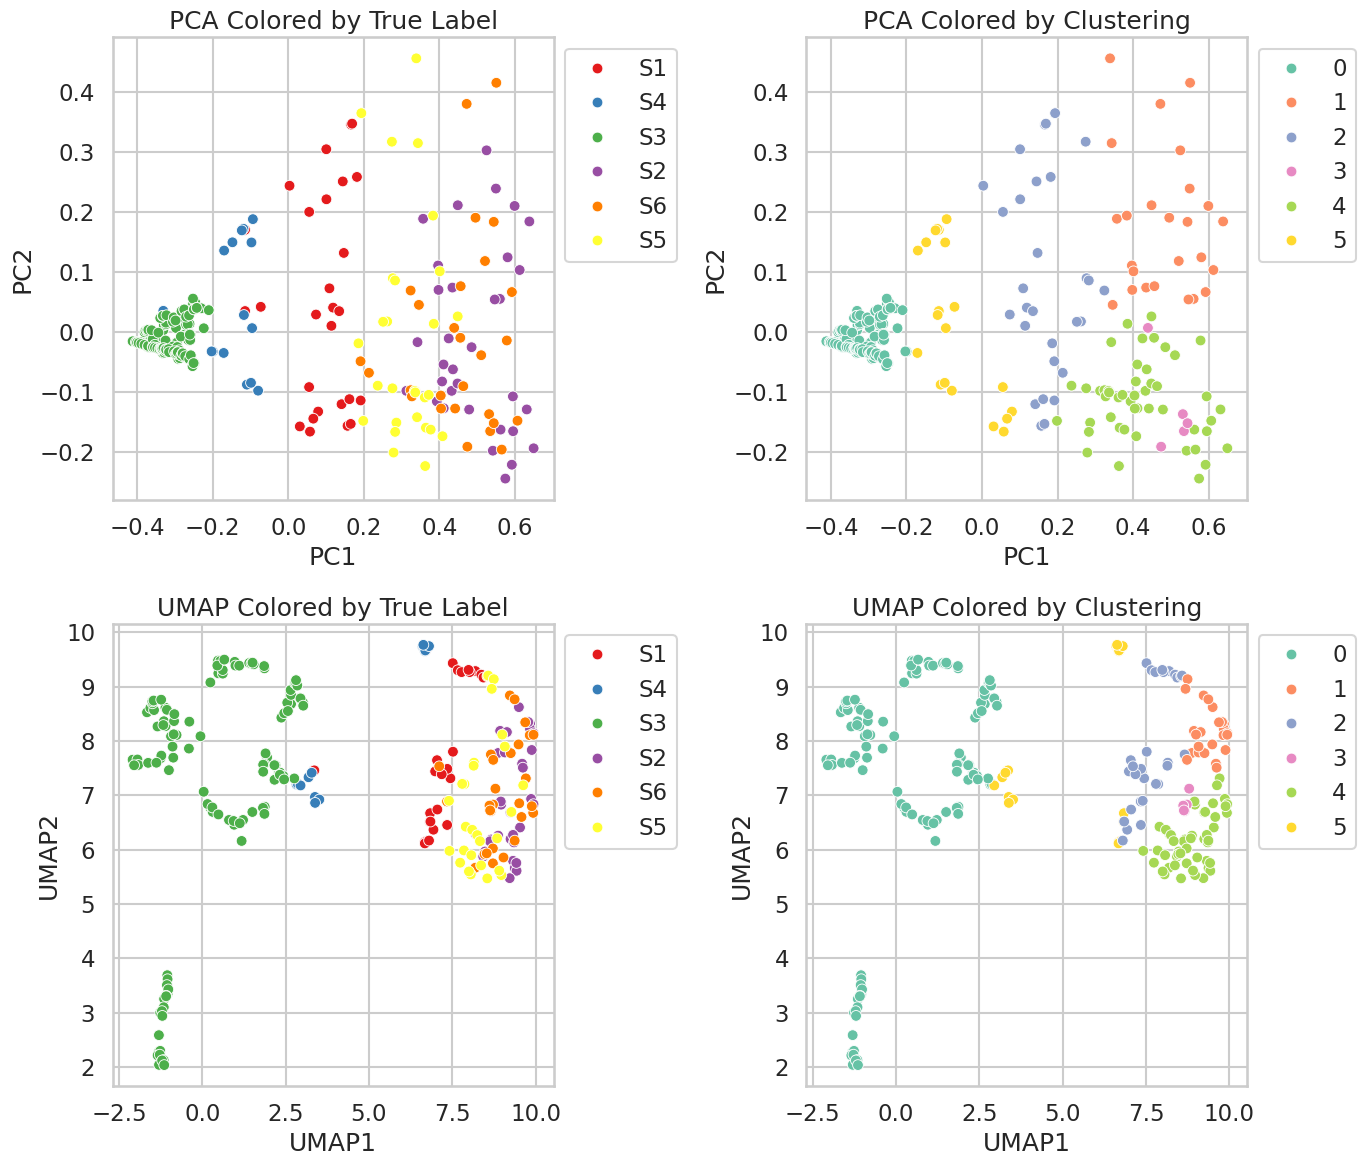

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
import umap
from sklearn.metrics import silhouette_score

FUNCTION_MAP = {
    'Visual Processing': [
        "O1", "O2", "Oz", "PO3", "PO4", "POz", "PO7", "PO8"
    ],
    'Auditory Processing': [
        "T7", "T8", "TP7", "TP8", "FT7", "FT8", "TP9", "TP10"
    ],
    'Language Processing': [
        "F7", "FC5", "FC3", "F3", "T7", "TP7", "CP5"
    ],
    'Motor Control': [
        "C3", "C4", "Cz", "CP3", "CP4", "CPz"
    ],
    'Executive Function / Attention': [
        "Fp1", "Fp2", "AF3", "AF4", "Fz", "F1", "F2", "F3", "F4", "F5"
    ],
    'Somatosensory Processing': [
        "CP1", "CP2", "CP3", "CP4", "P1", "P2", "P3", "P4"
    ],
    'Memory / Default Mode Network': [
        "Pz", "POz", "Oz", "Cz", "Fz"
    ],
    'Emotion / Limbic': [
        "Fp1", "Fp2", "AF7", "AF8"
    ]
}

# Improved feature extractor with normalized counts
def func_normalized_counts(graph):
    labels = graph['node_labels'].values()
    counts = {f: 0 for f in FUNCTION_MAP}
    for ch in labels:
        for f, ch_list in FUNCTION_MAP.items():
            if ch in ch_list:
                counts[f] += 1
    total_nodes = len(labels)
    if total_nodes > 0:
        norm_counts = [counts[f]/total_nodes for f in FUNCTION_MAP]
    else:
        norm_counts = [0]*len(FUNCTION_MAP)
    return norm_counts

# Extract normalized functional features for all graphs
X_func = np.array([func_normalized_counts(g) for g in list_of_graphs])

# Scale PEC values
pec_scaled = MinMaxScaler().fit_transform(np.array(pec_values).reshape(-1, 1))

# Interaction features: PEC * normalized functional counts (excluding node count)
interaction = pec_scaled * X_func

# Combine: normalized function features + node count + PEC + interactions
X = np.hstack([pec_scaled, interaction])

# Clustering algorithms to run
clustering_algos = {
    "KMeans": KMeans(n_clusters=6, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=6, linkage="average"),
    "Spectral": SpectralClustering(n_clusters=6, affinity='nearest_neighbors', n_neighbors=5, assign_labels='kmeans', random_state=42),
}

ari_scores = {}
cluster_preds = {}

for name, algo in clustering_algos.items():
    preds = algo.fit_predict(X)
    ari = adjusted_rand_score(true_labels, preds)
    ari_scores[name] = ari
    cluster_preds[name] = preds
    print(f"Silhouette score with {name}:", silhouette_score(X, preds))

print("Adjusted Rand Index (ARI) per Clustering Algorithm:")
for name, score in ari_scores.items():
    print(f"{name:<15}: {score:.3f}")

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Prepare DataFrame for plotting
df = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "UMAP1": X_umap[:,0],
    "UMAP2": X_umap[:,1],
    "TrueLabel": [str(t) for t in true_labels],
    "KMeans": cluster_preds["KMeans"],
    "Agglomerative": cluster_preds["Agglomerative"],
    "Spectral": cluster_preds["Spectral"],
})

# Plot PCA colored by true label and clusters
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x="PC1", y="PC2", hue="TrueLabel", palette="Set1", s=60)
plt.title("PCA Colored by True Label")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x="PC1", y="PC2", hue="KMeans", palette="Set2", s=60)
plt.title("PCA Colored by Clustering")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Plot UMAP colored by true label and clusters
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="TrueLabel", palette="Set1", s=60)
plt.title("UMAP Colored by True Label")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="KMeans", palette="Set2", s=60)
plt.title("UMAP Colored by Clustering")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()


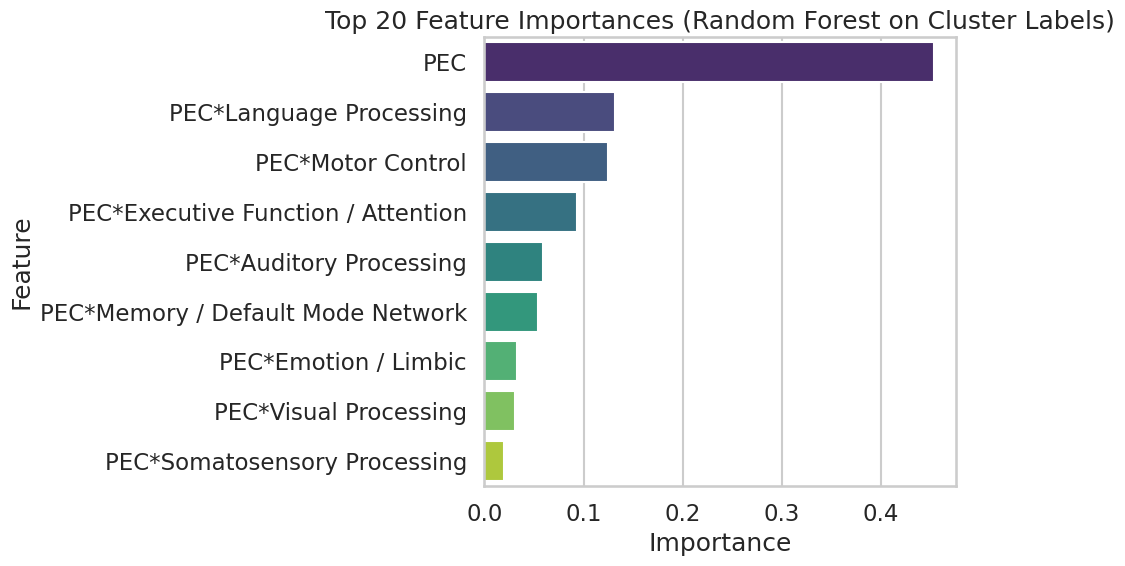

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Use cluster labels from Agglomerative clustering as pseudo-labels
y_clusters = cluster_preds["Agglomerative"]

# Use original high-dimensional features (not PCA/UMAP) for feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_clusters)

# Get feature importances
importances = rf.feature_importances_

# --- Labeling features ---
# Functional features (normalized node counts)
func_feats = list(FUNCTION_MAP.keys())

# PEC and interactions
pec_feats = ["PEC"]
interaction_feats = [f"PEC*{f}" for f in func_feats]

# Final feature order (as used in X: PEC + interactions)
feature_names = pec_feats + interaction_feats

# Sanity check
assert len(feature_names) == X.shape[1], "Feature name count doesn't match input shape."

# Create DataFrame
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(20), x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Feature Importances (Random Forest on Cluster Labels)")
plt.tight_layout()
plt.show()
